# Problem: Home Credit Default Risk

description: (if any)

summary: (if any)

Table of Content:
 - a
 - b

Project Set-up
 - Features
 - Model Consideration
    - Decision Tree Classifier
    - Random Forest Classifier
    - Hist Gradient Boosting Classifier
- Data Split Threshold (train:valid:test) -> 80:10:10
- Evaluation Metrics: Area under ROC curve

# Import Library

In [32]:
import os
import re
import json
import math
from typing import Dict, List, Union, Tuple, Optional
from functools import reduce

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# project root path
dir_project_root = os.path.dirname(os.getcwd())

# project sub directory
dir_raw_data = os.path.join(dir_project_root, 'data')

# path to data
path_application_train = os.path.join(dir_raw_data, 'application_train.csv')
path_application_test = os.path.join(dir_raw_data, 'application_test.csv')

path_bereau = os.path.join(dir_raw_data, 'bureau.csv')
path_bereau_balance = os.path.join(dir_raw_data, 'bureau_balance.csv')

path_previous_application = os.path.join(dir_raw_data, 'previous_application.csv')
path_pos_cash_balance = os.path.join(dir_raw_data, 'POS_CASH_balance.csv')
path_installment_payments = os.path.join(dir_raw_data, 'installments_payments.csv')
path_credit_card_balance = os.path.join(dir_raw_data, 'credit_card_balance.csv')

In [3]:
# make path (raw feature)
dir_preprocess_data = os.path.join(dir_raw_data, 'process')

dir_preprocess_data_artifacts = os.path.join(dir_preprocess_data, 'objects')
dir_preprocess_data_features = os.path.join(dir_preprocess_data, 'features')

for dir in [dir_preprocess_data, dir_preprocess_data_artifacts, dir_preprocess_data_features]:
    if not os.path.exists(dir):
        os.makedirs(dir)

# make path (modeling feature)
dir_preprocess_data_model = os.path.join(dir_preprocess_data, 'model')
dir_preprocess_data_model_train = os.path.join(dir_preprocess_data_model, 'train')
dir_preprocess_data_model_valid = os.path.join(dir_preprocess_data_model, 'valid')
dir_preprocess_data_model_test = os.path.join(dir_preprocess_data_model, 'test')

for dir in [dir_preprocess_data_model, dir_preprocess_data_model_train, dir_preprocess_data_model_valid, dir_preprocess_data_model_test]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [4]:
RANDOM_SEED = 99

# Import Data

In [5]:
# application train-test data
df_application_train = pd.read_csv(path_application_train)
df_application_test = pd.read_csv(path_application_test)

In [6]:
# bereau data
df_bereau = pd.read_csv(path_bereau)
df_bereau_balance = pd.read_csv(path_bereau_balance)

# previous application data
df_previous_application = pd.read_csv(path_previous_application)
df_pos_cash_balance = pd.read_csv(path_pos_cash_balance)
df_installment_payments = pd.read_csv(path_installment_payments)
df_credit_card_balance = pd.read_csv(path_credit_card_balance)

In [7]:
col_name_target = 'TARGET'
col_name_id = 'SK_ID_CURR'

list_col_pat_external = [r'EXT_SOURCE_(1|2|3)', r'APARTMENTS_(AVG|MODE|MEDI)', r'BASEMENTAREA_(AVG|MODE|MEDI)', r'YEARS_BEGINEXPLUATATION_', 
                         r'YEARS_BUILD_(AVG|MODE|MEDI)', r'COMMONAREA_(AVG|MODE|MEDI)', r'ELEVATORS_(AVG|MODE|MEDI)', r'ENTRANCES_(AVG|MODE|MEDI)', 
                         r'FLOORSMAX_(AVG|MODE|MEDI)', r'FLOORSMIN_(AVG|MODE|MEDI)', r'LANDAREA_(AVG|MODE|MEDI)', r'LIVINGAPARTMENTS_(AVG|MODE|MEDI)',
                         r'LIVINGAREA_(AVG|MODE|MEDI)', r'NONLIVINGAPARTMENTS_(AVG|MODE|MEDI)', r'NONLIVINGAREA_(AVG|MODE|MEDI)', 'TOTALAREA_MODE']

list_col_name_not_include = [col_name_target, col_name_id]
list_col_name_obj = df_application_train.select_dtypes(include='object').drop(columns=list_col_name_not_include, errors='ignore').columns.tolist()
list_col_name_nominal_from_description = [
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'
]

list_col_name_nominal = [*list_col_name_obj, *list_col_name_nominal_from_description]
list_col_name_numeric = [col for col in df_application_train.columns if col not in [*list_col_name_not_include, *list_col_name_nominal]]

# PART I - Exploratory Data Analysis

In [5]:
def explore_nominal_column(df, col_name, list_col_name_nominal=list_col_name_nominal):
    if col_name not in list_col_name_nominal:
        raise ValueError('Invalid nominal column name')
    
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    
    n_nan = df[col_name].isnull().sum()
    n_unique_values = df[col_name].nunique()
    list_unique_values = df[col_name].unique().tolist()
    arr_value_counts = df[col_name].value_counts()

    print('Column name: {}'.format(col_name))
    print('Number of NaN values: {}'.format(n_nan))
    print('Number of n unique class: {}'.format(n_unique_values))
    print('List of unique values: {}'.format(list_unique_values))
    print('Unique values count:')
    arr_value_counts.plot(kind='barh', ax=ax)
    ax.invert_yaxis()
    plt.show()
    fig.clf()

def explore_numeric_column(df, col_name, list_col_name_numeric):
    if col_name not in list_col_name_numeric:
        raise ValueError('Invalid numeric column name')
    
    fig, axs = plt.subplots(1, 2, figsize=(6, 3))

    n_nan = df[col_name].isnull().sum()
    statistic_col = df[col_name].describe()

    mean_value = statistic_col.loc['mean']
    std_value = statistic_col.loc['std']
    min_value = statistic_col.loc['min']
    q1_value = statistic_col.loc['25%']
    q2_value = statistic_col.loc['50%']
    q3_value = statistic_col.loc['75%']
    max_value = statistic_col.loc['max']

    print('Column name: {}'.format(col_name))
    print('Number of NaN values: {}'.format(n_nan))
    print('Statistics:')
    print('  - Mean: {}'.format(mean_value))
    print('  - Standard Deviasion: {}'.format(std_value))
    print('  - Minimum: {}'.format(min_value))
    print('  - Q1: {}'.format(q1_value))
    print('  - Median: {}'.format(q2_value))
    print('  - Q3: {}'.format(q3_value))
    print('  - Max: {}'.format(max_value))
    print('Distribution:')
    df[col_name].hist(bins=30, ax=axs[0])
    df.boxplot(column=col_name, ax=axs[1])
    plt.show()
    fig.clf()

def explore_initial_data(df):
    n_row, n_col = df.shape
    arr_count_nan = df.isnull().sum()
    n_col_nan = len(arr_count_nan[arr_count_nan > 0])
    list_col_types = df.dtypes.unique()

    print("Number of rows: {}".format(n_row))
    print("Number of columns: {}".format(n_col))
    print("Number of NaN columns: {}".format(n_col_nan))
    print("Col dtypes: {}".format(list_col_types))

def check_data_completeness_id(df_ref, df_check, col_name_ref, col_name_id):
    df_check_filter = df_check.loc[:, [col_name_id, col_name_ref]]
    df_ref_filter = df_ref.loc[:, [col_name_id]]

    df_check_nondup = df_check_filter.drop_duplicates(subset=col_name_id)
    df_for_count = df_ref_filter.merge(df_check_nondup, left_on=col_name_id, right_on=col_name_id, how='left')
    
    n_missins_records = df_for_count[col_name_ref].isna().sum()
    
    print("Number of missing records when join: {}".format(n_missins_records))

### Data exploration in Application data

#### <u>Initial inspection on dataset</u>

In [31]:
df_application_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
explore_initial_data(df_application_train)

Number of rows: 307511
Number of columns: 122
Number of NaN columns: 67
Col dtypes: [dtype('int64') dtype('O') dtype('float64')]


In [87]:
n_unique_id = len(df_application_train[col_name_id].unique())
n_row = df_application_train.shape[0]

print("Number of rows in dataset: {}".format(n_row))
print("Number of unique id in the dataset: {}".format(n_unique_id))

Number of rows in dataset: 307511
Number of unique id in the dataset: 307511


#### <u>Target column exploration</u>

##### <b>Insight 1:</b>

We have imbalanced data (proportion for each class in target variable is not the same)

In [25]:
df_application_train[col_name_target].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

#### <u>Nominal column exploration</u>

##### <b>Insight 1:</b>

Some nominal columns contain categories that only have few amount of records

<u>Appoach</u>: setting threshold as a percentage of total number of records to remove those low-frequency categories

<em>Those columns are including: <code>['CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']</code></em>

Column name: NAME_TYPE_SUITE
Number of NaN values: 1292
Number of n unique class: 7
List of unique values: ['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', nan, 'Other_B', 'Group of people']
Unique values count:


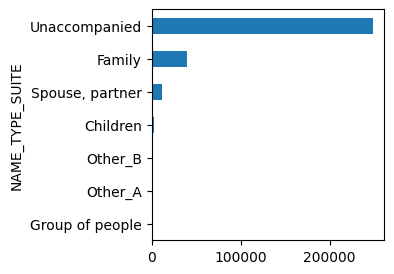

In [22]:
explore_nominal_column(df_application_train, col_name='NAME_TYPE_SUITE', list_col_name_nominal=list_col_name_nominal)

##### <b>Insight 2:</b>

Some nominal columns contain categories that could be grouped into theri main category

<u>Appoach</u>: grouping some categories into the same group considering definitions and low-frequency threshold

<em>Those columns are including: <code>['OCCUPATION_TYPE', 'ORGANIZATION_TYPE']</code></em>

Column name: OCCUPATION_TYPE
Number of NaN values: 96391
Number of n unique class: 18
List of unique values: ['Laborers', 'Core staff', 'Accountants', 'Managers', nan, 'Drivers', 'Sales staff', 'Cleaning staff', 'Cooking staff', 'Private service staff', 'Medicine staff', 'Security staff', 'High skill tech staff', 'Waiters/barmen staff', 'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff']
Unique values count:


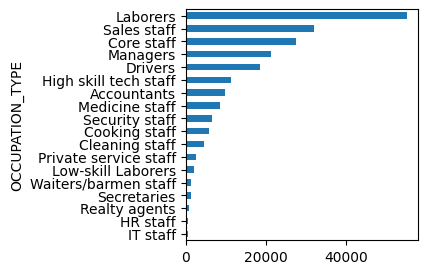

In [23]:
explore_nominal_column(df_application_train, col_name='OCCUPATION_TYPE', list_col_name_nominal=list_col_name_nominal)

##### <b>Insight 3:</b>

Some nominal columns only mainly contains 1 category (with/without NaN)

<u>Appoach</u>: remove these columns

<em>Those columns are including: <code>['HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE', 'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 
    'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']</code></em>

Column name: HOUSETYPE_MODE
Number of NaN values: 154297
Number of n unique class: 3
List of unique values: ['block of flats', nan, 'terraced house', 'specific housing']
Unique values count:


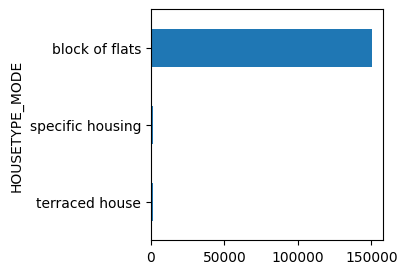

In [24]:
explore_nominal_column(df_application_train, col_name='HOUSETYPE_MODE', list_col_name_nominal=list_col_name_nominal)

#### <u>Numeric column exploration</u>

##### <b>Insight 1:</b>

Most of numeric columns which are contain lots of NaN values are <b>"External"</b> columns

<u>Appoach</u>: 
 - find the way to fill NaN on these columns, e.g., fit model with external data itself to avoid imputing bias
 - <b>fit the model that could handle NaN</b>

<em>Note:
 - These data are already normalized in [0, 1] scale
 - These column are highly correlated with those columns aggregated from either same or similar data source</em>

In [82]:
null_threshold = 0.4

arr_count_nan = df_application_train.loc[:, list_col_name_numeric].isnull().sum()
list_col_name_numeric_nan = arr_count_nan[arr_count_nan > df_application_train.shape[0] * null_threshold].index.to_list()

n_col_numeric_nan = len(list_col_name_numeric_nan)
n_col_numeric_ext = sum(map(lambda y: any(map(lambda x: bool(re.match(x, y)), list_col_pat_external)), list_col_name_numeric))
n_col_numeric_ext_nan = sum(map(lambda y: any(map(lambda x: bool(re.match(x, y)), list_col_pat_external)), list_col_name_numeric_nan))

print("[NaN threshold = {}%]".format(round(null_threshold * 100, 2)))
print("Number of numeric column contains NaN: {}".format(n_col_numeric_nan))
print("Number of \"External\" numeric column contains NaN: {} (from total {})".format(n_col_numeric_ext_nan, n_col_numeric_ext))

[NaN threshold = 40.0%]
Number of numeric column contains NaN: 45
Number of "External" numeric column contains NaN: 44 (from total 46)


##### <b>Insight 2:</b>

Some numeric columns are not truely continuous

<u>Appoach</u>: group values into bucket if using <b>non tree-based</b> model

 <em>Those columns are including: <code>['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE']</code></em>

Column name: CNT_CHILDREN
Number of NaN values: 0
Statistics:
  - Mean: 0.4170517477423572
  - Standard Deviasion: 0.7221213844376252
  - Minimum: 0.0
  - Q1: 0.0
  - Median: 0.0
  - Q3: 1.0
  - Max: 19.0
Distribution:


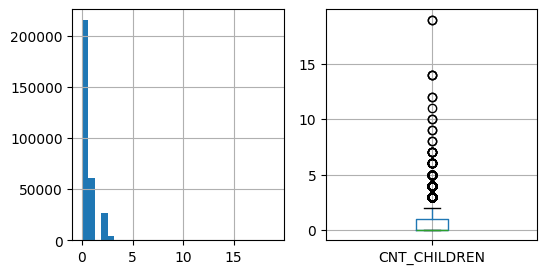

In [83]:
explore_numeric_column(df_application_train, col_name='CNT_CHILDREN', list_col_name_numeric=list_col_name_numeric)

##### <b>Insight 3:</b>

Some numeric columns contains outlier

<u>Appoach</u>:
 - remove outlier in column <code>'AMT_INCOME_TOTAL'</code>
 - use IQR range to cap outliers in other columns

 <em>Those columns are including: <code>['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'YEARS_BUILD_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE']</code></em>

Column name: AMT_INCOME_TOTAL
Number of NaN values: 0
Statistics:
  - Mean: 168797.9192969845
  - Standard Deviasion: 237123.14627885626
  - Minimum: 25650.0
  - Q1: 112500.0
  - Median: 147150.0
  - Q3: 202500.0
  - Max: 117000000.0
Distribution:


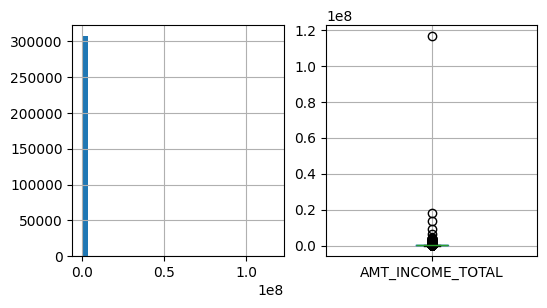

In [105]:
explore_numeric_column(df_application_train, col_name='AMT_INCOME_TOTAL', list_col_name_numeric=list_col_name_numeric)

##### <b>Insight 4:</b>

Some weird values in <code>DAY_EMPLOYED</code> columns

<u>Appoach</u>: Minimum clip on <code>DAY_EMPLOYED</code> column (with 0 values)

Column name: DAYS_EMPLOYED
Number of NaN values: 0
Statistics:
  - Mean: 63815.04590404896
  - Standard Deviasion: 141275.76651872724
  - Minimum: -17912.0
  - Q1: -2760.0
  - Median: -1213.0
  - Q3: -289.0
  - Max: 365243.0
Distribution:


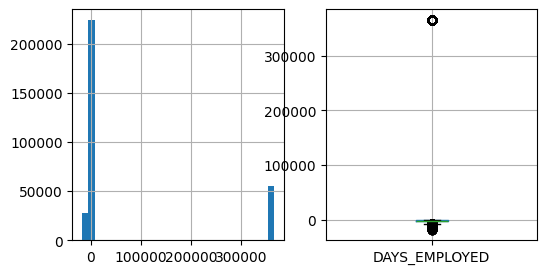

In [109]:
explore_numeric_column(df_application_train, col_name='DAYS_EMPLOYED', list_col_name_numeric=list_col_name_numeric)

##### <b>Insight 5:</b>

Variant scale of data

<u>Appoach</u>: Normalize numerical variables to [0, 1] scale

##### <b>Insight 6:</b>

External numeric columns are highly correlated with those aggregated from either same or similar data source

<u>Appoach</u>: Don't forget to remove redundant variables

##### <b>Insight 7:</b>

Some numeric columns are actually ordinal data

<u>Appoach</u>: drop these columns since most data are fall into one category

 <em>Those columns are including: <code>['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']</code></em>

Column name: AMT_REQ_CREDIT_BUREAU_WEEK
Number of NaN values: 41519
Number of n unique class: 9
List of unique values: [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, 7.0]
Unique values count:


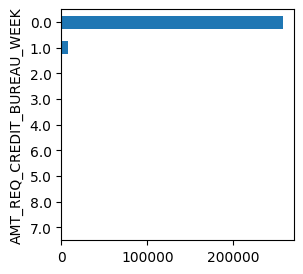

In [118]:
explore_nominal_column(df_application_train, col_name='AMT_REQ_CREDIT_BUREAU_WEEK', list_col_name_nominal=['AMT_REQ_CREDIT_BUREAU_WEEK'])

### Data exploration in Bereau data

#### <u>Initial inspection on dataset</u>

In [82]:
df_bereau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [117]:
df_bereau.loc[df_bereau[col_name_id] == 162297]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.0,0.0,0.0,Consumer credit,-1710,NaN
8,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.0,0.0,0.0,Consumer credit,-840,NaN
9,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.0,0.0,0.0,Credit card,-690,NaN
10,162297,5714472,Active,currency 1,-1146,0,-180.0,NaN,0.0,0,337500.00,0.0,0.0,0.0,Credit card,-690,NaN
11,162297,5714473,Closed,currency 1,-2456,0,-629.0,-825.0,NaN,0,675000.00,0.0,0.0,0.0,Consumer credit,-706,NaN
12,162297,5714474,Active,currency 1,-277,0,5261.0,NaN,0.0,0,7033500.00,NaN,NaN,0.0,Mortgage,-31,NaN


In [81]:
explore_initial_data(df_bereau)

Number of rows: 1716428
Number of columns: 17
Number of NaN columns: 7
Col dtypes: [dtype('int64') dtype('O') dtype('float64')]


In [14]:
df_bereau.isnull().sum()

SK_ID_CURR                      0
SK_ID_BUREAU                    0
CREDIT_ACTIVE                   0
CREDIT_CURRENCY                 0
DAYS_CREDIT                     0
CREDIT_DAY_OVERDUE              0
DAYS_CREDIT_ENDDATE        105553
DAYS_ENDDATE_FACT          633653
AMT_CREDIT_MAX_OVERDUE    1124488
CNT_CREDIT_PROLONG              0
AMT_CREDIT_SUM                 13
AMT_CREDIT_SUM_DEBT        257669
AMT_CREDIT_SUM_LIMIT       591780
AMT_CREDIT_SUM_OVERDUE          0
CREDIT_TYPE                     0
DAYS_CREDIT_UPDATE              0
AMT_ANNUITY               1226791
dtype: int64

In [94]:
check_data_completeness_id(df_application_train, df_bereau, col_name_ref='SK_ID_BUREAU', col_name_id=col_name_id)

Number of missing records when join: 44020


#### <u>Nominal column exploration</u>

##### <b>Insight 1:</b>

Some nominal columns contain categories that only have few amount of records

<u>Appoach</u>:
 - Filter out ('Sold', 'Bad debt') category in <code>'CREDIT_ACTIVE'</code> column
 - Filter out ('currency 2', 'currency 4', 'currency 3') category in <code>'CREDIT_CURRENCY'</code> column
 - Cross-reference credit bureau status with Bureau Balance data

Column name: CREDIT_ACTIVE
Number of NaN values: 0
Number of n unique class: 4
List of unique values: ['Closed', 'Active', 'Sold', 'Bad debt']
Unique values count:


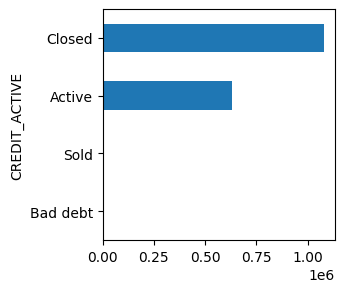

Column name: CREDIT_CURRENCY
Number of NaN values: 0
Number of n unique class: 4
List of unique values: ['currency 1', 'currency 2', 'currency 4', 'currency 3']
Unique values count:


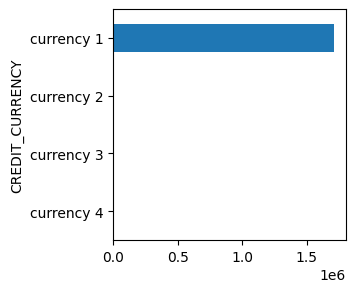

Column name: CREDIT_TYPE
Number of NaN values: 0
Number of n unique class: 15
List of unique values: ['Consumer credit', 'Credit card', 'Mortgage', 'Car loan', 'Microloan', 'Loan for working capital replenishment', 'Loan for business development', 'Real estate loan', 'Unknown type of loan', 'Another type of loan', 'Cash loan (non-earmarked)', 'Loan for the purchase of equipment', 'Mobile operator loan', 'Interbank credit', 'Loan for purchase of shares (margin lending)']
Unique values count:


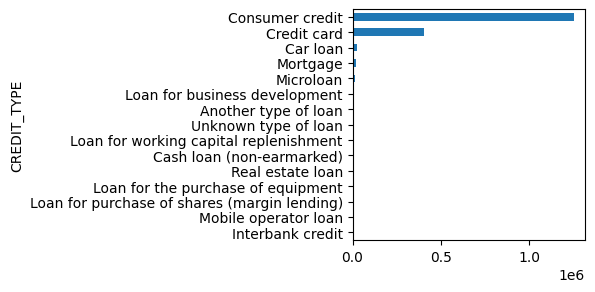

In [101]:
for col in ('CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE'):
    explore_nominal_column(df_bereau, col_name=col, list_col_name_nominal=[col])

#### <u>Numeric column exploration</u>

##### <b>Insight 1:</b>

Some records in credit bereau dataset are out-of-date or have a weird value in <code>'DAYS_CREDIT_UPDATE'</code>

<u>Appoach</u>:
 - Filter out value > 0 in <code>'DAYS_CREDIT_UPDATE'</code> column
 - Filter out out-to-date records in <code>'DAYS_CREDIT_UPDATE'</code> column

Column name: DAYS_CREDIT_UPDATE
Number of NaN values: 0
Statistics:
  - Mean: -593.7483197663986
  - Standard Deviasion: 720.7473115011627
  - Minimum: -41947.0
  - Q1: -908.0
  - Median: -395.0
  - Q3: -33.0
  - Max: 372.0
Distribution:


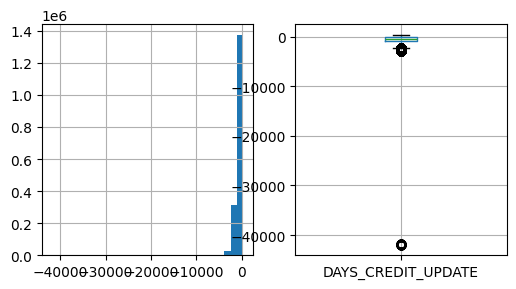

In [124]:
explore_numeric_column(df_bereau, col_name='DAYS_CREDIT_UPDATE', list_col_name_numeric=['DAYS_CREDIT_UPDATE'])

##### <b>Insight 2:</b>

There are some outliers in column <code>'CREDIT_DAY_OVERDUE'</code> that appears to be expired credit bureau

<u>Appoach</u>: clean those expired credit bureau

Column name: CREDIT_DAY_OVERDUE
Number of NaN values: 0
Statistics:
  - Mean: 0.8181665645165425
  - Standard Deviasion: 36.54442800616701
  - Minimum: 0.0
  - Q1: 0.0
  - Median: 0.0
  - Q3: 0.0
  - Max: 2792.0
Distribution:


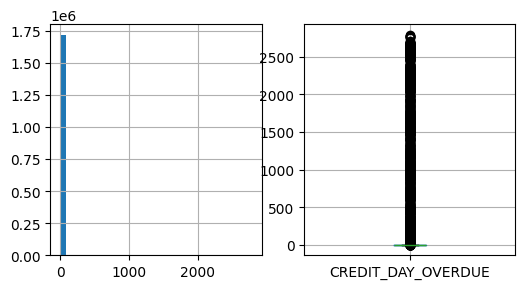

In [126]:
explore_numeric_column(df_bereau, col_name='CREDIT_DAY_OVERDUE', list_col_name_numeric=['CREDIT_DAY_OVERDUE'])

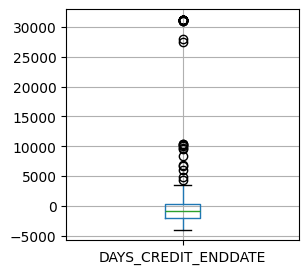

In [143]:
n_days_overdue = 90

fig, ax = plt.subplots(figsize=(3, 3))
df_bereau.loc[df_bereau.CREDIT_DAY_OVERDUE > n_days_overdue].boxplot(column='DAYS_CREDIT_ENDDATE', ax=ax)
plt.show()
fig.clf()

##### <b>Insight 3:</b>

There are some outliers in column <code>'DAYS_CREDIT_ENDDATE'</code>

<u>Appoach</u>:
 - Remove rows which are 'Active' status but have <code>'DAYS_CREDIT_ENDDATE'</code> < 0
 - Remove rows which are 'Closed' status but have <code>'DAYS_CREDIT_ENDDATE'</code> > 0
 - Don't use those positive outlier values from 'Credit card' loan type

Column name: DAYS_CREDIT_ENDDATE
Number of NaN values: 105553
Statistics:
  - Mean: 510.51736230309615
  - Standard Deviasion: 4994.219837125882
  - Minimum: -42060.0
  - Q1: -1138.0
  - Median: -330.0
  - Q3: 474.0
  - Max: 31199.0
Distribution:


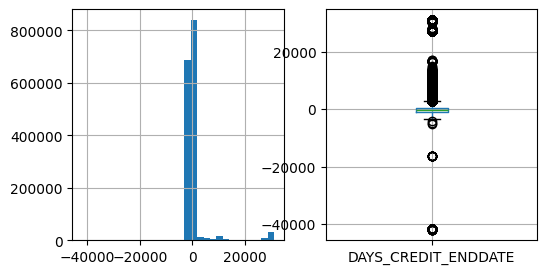

In [144]:
explore_numeric_column(df_bereau, col_name='DAYS_CREDIT_ENDDATE', list_col_name_numeric=['DAYS_CREDIT_ENDDATE'])

In [147]:
df_bereau.loc[df_bereau['CREDIT_ACTIVE'] == 'Active', 'DAYS_CREDIT_ENDDATE'].describe()

count    558111.000000
mean       2547.215375
std        7006.454056
min      -42056.000000
25%         173.000000
50%         678.000000
75%        1289.000000
max       31199.000000
Name: DAYS_CREDIT_ENDDATE, dtype: float64

In [148]:
df_bereau.loc[df_bereau['CREDIT_ACTIVE'] == 'Closed', 'DAYS_CREDIT_ENDDATE'].describe()

count    1.046843e+06
mean    -5.709404e+02
std      2.963936e+03
min     -4.206000e+04
25%     -1.485000e+03
50%     -8.060000e+02
75%     -2.760000e+02
max      3.119800e+04
Name: DAYS_CREDIT_ENDDATE, dtype: float64

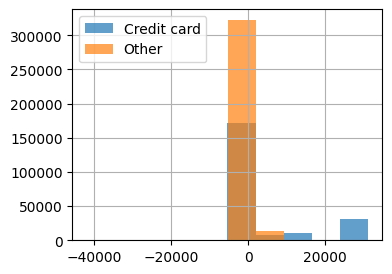

In [153]:
fig, ax = plt.subplots(figsize=(4, 3))
df_bereau['col_groupby'] = np.where(df_bereau.CREDIT_TYPE.eq('Credit card'), 'Credit card', 'Other')
df_bereau.loc[df_bereau.CREDIT_ACTIVE == 'Active'].groupby('col_groupby')['DAYS_CREDIT_ENDDATE'].hist(alpha=0.7, ax=ax, legend=True)
plt.show()
fig.clf()

del df_bereau['col_groupby']

##### <b>Insight 4:</b>

There are some outliers in column <code>['DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE']</code>

<u>Appoach</u>: remove outliers in column

Column name: DAYS_ENDDATE_FACT
Number of NaN values: 633653
Statistics:
  - Mean: -1017.43714806862
  - Standard Deviasion: 714.0106263423945
  - Minimum: -42023.0
  - Q1: -1489.0
  - Median: -897.0
  - Q3: -425.0
  - Max: 0.0
Distribution:


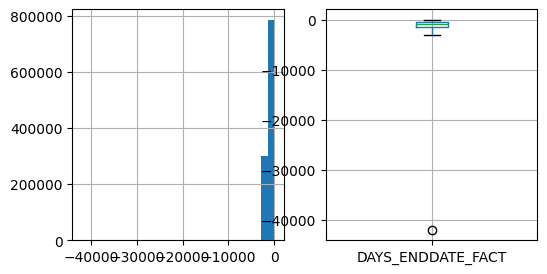

In [154]:
explore_numeric_column(df_bereau, col_name='DAYS_ENDDATE_FACT', list_col_name_numeric=['DAYS_ENDDATE_FACT'])

#### <u>Feature engineering on Credit Bereau</u>
- Has credit bureau record?
- Count number of active loans
- Latest application on previous loan
- Count number of loan past due (keep both sources)
- Is previous loan past due ('Closed' status)
- Is active loan past due ('Active' status)
- Maximum of <code>DAYS_CREDIT_ENDDATE</code> for non 'Credit card' loans
- Minimum of <code>DAYS_ENDDATE_FACT</code> for 'Closed' loans
- Sum amount of <code>AMT_CREDIT_SUM_DEBT</code>

### Data exploration in Bureau Balance data

##### <u>Initial inspection on dataset</u>

In [158]:
df_bereau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [159]:
explore_initial_data(df_bereau_balance)

Number of rows: 27299925
Number of columns: 3
Number of NaN columns: 0
Col dtypes: [dtype('int64') dtype('O')]


##### <u>Data inconsistencies on previous Bereau dataset</u>

##### <b>Insight 1:</b>

There are some inconsistensies on credit bureau status between Bureau dataset and Bureau Balance dataset

<u>Appoach</u>:
- cross-reference latest status on Bureau data (C / A)
- determine overdue status directly from Bereau Balance dataset

In [ ]:
df_bereau.loc[df_bereau.SK_ID_BUREAU == 5715448]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
768,380361,5715448,Active,currency 1,-820,0,31069.0,NaN,NaN,0,67500.0,0.0,67500.0,0.0,Credit card,-183,0.0


In [163]:
df_bereau_balance.loc[df_bereau_balance.SK_ID_BUREAU == 5715448].head(4)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C


Column name: STATUS
Number of NaN values: 0
Number of n unique class: 8
List of unique values: ['C', '0', 'X', '1', '2', '3', '5', '4']
Unique values count:


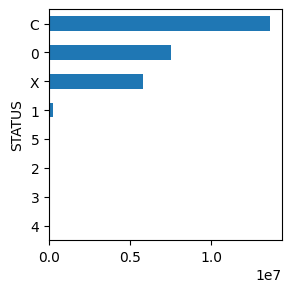

In [160]:
explore_nominal_column(df_bereau_balance, col_name='STATUS', list_col_name_nominal=['STATUS'])

### Data exploration in Previous Application data

In [ ]:
list_col_name_ids = ['SK_ID_PREV', 'SK_ID_CURR']
list_col_name_str = df_previous_application.select_dtypes(include='object').columns.tolist() + ['NFLAG_LAST_APPL_IN_DAY', 'NFLAG_INSURED_ON_APPROVAL']
list_col_name_numeric = [col for col in df_previous_application.columns if col not in [*list_col_name_ids, *list_col_name_str]]

#### <u>Initial inspection on dataset</u>

In [150]:
df_previous_application.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


In [172]:
df_previous_application.loc[df_previous_application[col_name_id] == 162297]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
229247,2513435,162297,Consumer loans,9069.840,82332.9,75645.0,13500.9,82332.9,THURSDAY,10,...,Consumer electronics,12.0,high,POS household with interest,365243.0,-2136.0,-1806.0,-1806.0,-1800.0,0.0
1092526,1155486,162297,Consumer loans,5257.215,33957.0,26194.5,9000.0,33957.0,TUESDAY,16,...,Connectivity,6.0,low_normal,POS mobile with interest,365243.0,-2831.0,-2681.0,-2681.0,-2633.0,1.0


In [153]:
explore_initial_data(df_previous_application)

Number of rows: 1670214
Number of columns: 37
Number of NaN columns: 16
Col dtypes: [dtype('int64') dtype('O') dtype('float64')]


In [157]:
df_previous_application.isnull().sum()[df_previous_application.isnull().sum() > 0]

AMT_ANNUITY                   372235
AMT_CREDIT                         1
AMT_DOWN_PAYMENT              895844
AMT_GOODS_PRICE               385515
RATE_DOWN_PAYMENT             895844
RATE_INTEREST_PRIMARY        1664263
RATE_INTEREST_PRIVILEGED     1664263
NAME_TYPE_SUITE               820405
CNT_PAYMENT                   372230
PRODUCT_COMBINATION              346
DAYS_FIRST_DRAWING            673065
DAYS_FIRST_DUE                673065
DAYS_LAST_DUE_1ST_VERSION     673065
DAYS_LAST_DUE                 673065
DAYS_TERMINATION              673065
NFLAG_INSURED_ON_APPROVAL     673065
dtype: int64

Drop column : <code>['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_TYPE_SUITE']</code>

In [179]:
row_cnt = df_previous_application.groupby(list_col_name_ids).size()
row_cnt[row_cnt > 1]

Series([], dtype: int64)

In [156]:
check_data_completeness_id(df_application_train, df_previous_application, col_name_ref='SK_ID_PREV', col_name_id=col_name_id)

Number of missing records when join: 16454


#### <u>Nominal column exploration</u>

##### <b>Insight 1:</b>

Some nominal columns contain categories that only have few amount of records

<u>Appoach</u>:
 - Only keep ('Consumer loans', 'Cash loans', 'Revolving loans') category in column <code>'NAME_CONTRACT_TYPE'</code>
 - Drop column <code>['NAME_PAYMENT_TYPE']</code>

Column name: NAME_CONTRACT_TYPE
Number of NaN values: 0
Number of n unique class: 4
List of unique values: ['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA']
Unique values count:


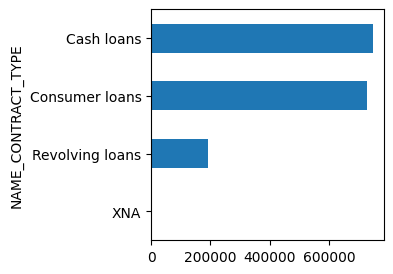

In [173]:
explore_nominal_column(df_previous_application, col_name='NAME_CONTRACT_TYPE', list_col_name_nominal=list_col_name_str)

##### <b>Insight 2:</b>

Some nominal columns are not related to the problem

<u>Appoach</u>: drop those columns

<em>Those columns are including: <code>['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 'NAME_TYPE_SUITE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']</code></em>

##### <b>Insight 3:</b>

According to data dict, there could be multiple applications for one single contact

<u>Appoach</u>: Flag 'Y' on column <code>'FLAG_LAST_APPL_PER_CONTRACT'</code>

In [183]:
df_previous_application['FLAG_LAST_APPL_PER_CONTRACT'].value_counts()

FLAG_LAST_APPL_PER_CONTRACT
Y    1661739
N       8475
Name: count, dtype: int64

#### <u>Numeric column exploration</u>

##### <b>Insight 1:</b>

Some "DAYS_*" columns contains weird values

<u>Appoach</u>: replace those weird values (value > 0) as NaN

<em>Those columns are including: <code>['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', DAYS_LAST_DUE', 'DAYS_TERMINATION']</code></em>

Column name: DAYS_LAST_DUE
Number of NaN values: 673065
Statistics:
  - Mean: 76582.40306413585
  - Standard Deviasion: 149647.4151231759
  - Minimum: -2889.0
  - Q1: -1314.0
  - Median: -537.0
  - Q3: -74.0
  - Max: 365243.0
Distribution:


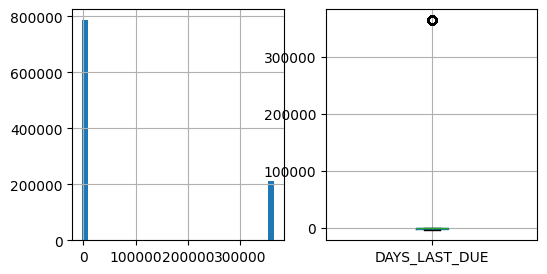

In [186]:
explore_numeric_column(df_previous_application, col_name='DAYS_LAST_DUE', list_col_name_numeric=['DAYS_LAST_DUE'])

In [ ]:
df_previous_application.loc[df_previous_application['DAYS_LAST_DUE'] > 0, 'DAYS_LAST_DUE'].value_counts()

DAYS_LAST_DUE
365243.0    211221
Name: count, dtype: int64

##### <b>Insight 2:</b>

Some numerical columns are not related to the problem

<u>Appoach</u>: drop those columns

<em>Those columns are including: <code>['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_TERMINATION']</code></em>

#### <u>Feature engineering on Previous Application</u>
- Is there any previous application or not
- Is all loans are approved
- Is there any loan rejected within the specified period
- Is there any loan cancelled within the specified period
- Last loan approval time if any (column <code>'DAYS_DECISION'</code>)
- Latest loan application / Last loan approval
- Latest client type (column <code>'NAME_CLIENT_TYPE'</code>)
- Maximum loan amount that was previously approved (column <code>'AMT_CREDIT'</code>)
- Current application amount / MAX(<code>'AMT_CREDIT'</code>)
- Minimun of days last due (column <code>'DAYS_LAST_DUE'</code>)
- Did client requested insurance during the latest application or not (column <code>'NFLAG_INSURED_ON_APPROVAL'</code>)

### Data exploration in POS Cash Balance

#### <u>Initail inspection on dataset</u>

In [277]:
df_pos_cash_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


In [279]:
explore_initial_data(df_pos_cash_balance)

Number of rows: 10001358
Number of columns: 8
Number of NaN columns: 2
Col dtypes: [dtype('int64') dtype('float64') dtype('O')]


In [280]:
df_pos_cash_balance.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64

In [40]:
check_data_completeness_id(df_ref=df_application_train, df_check=df_pos_cash_balance, col_name_ref='SK_ID_PREV', col_name_id='SK_ID_CURR')

Number of missing records when join: 18067


#### <u>Numeric column exploration</u>

Column name: SK_DPD
Number of NaN values: 0
Statistics:
  - Mean: 11.606928279139693
  - Standard Deviasion: 132.7140434930959
  - Minimum: 0.0
  - Q1: 0.0
  - Median: 0.0
  - Q3: 0.0
  - Max: 4231.0
Distribution:


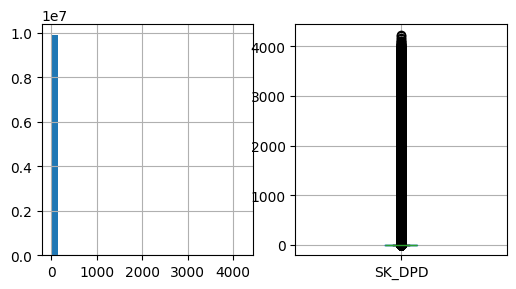

In [282]:
explore_numeric_column(df_pos_cash_balance, col_name='SK_DPD', list_col_name_numeric=['SK_DPD'])

#### <u>Feature engineering on Previous Application</u>
- Count number of months with DPD

### Data exploration in Installment Payments (last data used)

#### <u>Initail inspection on dataset</u>

In [35]:
df_installment_payments.head(3)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


In [61]:
df_installment_payments.loc[df_installment_payments['SK_ID_PREV'].eq(1054186)].sort_values(by='NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
577850,1054186,161674,1.0,1,-1330.0,-1338.0,6948.36,6948.36
47438,1054186,161674,1.0,2,-1300.0,-1307.0,6948.36,6948.36
425089,1054186,161674,1.0,3,-1270.0,-1275.0,6948.36,6948.36
3612113,1054186,161674,1.0,4,-1240.0,-1247.0,6948.36,6948.36
1878907,1054186,161674,1.0,5,-1210.0,-1217.0,6948.36,6948.36
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.36,6948.36
1128187,1054186,161674,1.0,7,-1150.0,-1175.0,6948.36,6948.36
138614,1054186,161674,1.0,8,-1120.0,-1175.0,6948.36,6948.36
1608829,1054186,161674,1.0,9,-1090.0,-1154.0,6948.36,6948.36
1038640,1054186,161674,1.0,10,-1060.0,-1125.0,6948.36,6948.36


In [36]:
explore_initial_data(df_installment_payments)

Number of rows: 13605401
Number of columns: 8
Number of NaN columns: 2
Col dtypes: [dtype('int64') dtype('float64')]


In [38]:
df_installment_payments.isnull().sum()

SK_ID_PREV                   0
SK_ID_CURR                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        2905
AMT_INSTALMENT               0
AMT_PAYMENT               2905
dtype: int64

In [39]:
check_data_completeness_id(df_ref=df_application_train, df_check=df_installment_payments, col_name_ref='SK_ID_PREV', col_name_id='SK_ID_CURR')

Number of missing records when join: 15868


#### <u>Numeric columns exploration on dataset</u>

##### <b>Insight 1:</b>

There are some weird payment amounts in which the amount of actual payment is greater than the installment amount for each payment

<u>Appoach</u>: capping the <code>'AMT_PAYMENT'</code> which greater that <code>'AMT_INSTALLMENT'</code>

In [72]:
tol = 1e-3
arr_diff_payment = df_installment_payments['AMT_INSTALMENT'] - df_installment_payments['AMT_PAYMENT']
arr_diff_payment[arr_diff_payment < tol].describe()

count    1.230700e+07
mean    -1.003783e+03
std      1.951634e+04
min     -2.630909e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
dtype: float64

In [74]:
df_installment_payments.loc[arr_diff_payment < -2].shape

(179316, 8)

In [70]:
df_installment_payments.loc[df_installment_payments.SK_ID_PREV == 2715881].sort_values(by='NUM_INSTALMENT_NUMBER')

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
224823,2715881,124670,1.0,1,-654.0,-661.0,58347.495,58347.495
2329237,2715881,124670,1.0,2,-624.0,-631.0,58347.495,58347.495
448976,2715881,124670,2.0,3,-594.0,-601.0,850957.515,909305.010
448977,2715881,124670,1.0,3,-594.0,-601.0,58347.495,909305.010
360,2715881,124670,3.0,4,-564.0,-572.0,7972.425,49500.000
361,2715881,124670,4.0,4,-564.0,-572.0,41527.575,49500.000
1255516,2715881,124670,6.0,5,-534.0,-540.0,3579.210,9000.000
1255517,2715881,124670,5.0,5,-534.0,-540.0,5420.790,9000.000
2013701,2715881,124670,7.0,6,-504.0,-512.0,5179.860,5179.860
2233421,2715881,124670,7.0,7,-474.0,-481.0,5179.860,5179.860


##### <b>Insight 2:</b>

There are some weird payments date in which the date of actual payment is drastically before (or after) the installment date for each payment

<u>Appoach</u>: 
 - capping the payment date difference which lower than -31 as -31
 - capping the payment date difference which greater than 31 as 31

In [75]:
arr_diff_payment_day = df_installment_payments['DAYS_INSTALMENT'] - df_installment_payments['DAYS_ENTRY_PAYMENT']
arr_diff_payment_day.describe()

count    1.360250e+07
mean     8.787405e+00
std      2.553990e+01
min     -2.884000e+03
25%      0.000000e+00
50%      6.000000e+00
75%      1.400000e+01
max      3.189000e+03
dtype: float64

In [77]:
df_installment_payments[arr_diff_payment_day < -1000]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3531,2346295,117570,0.0,58,-1654.0,-511.0,67.500,67.500
11009,2393092,189021,1.0,10,-2116.0,-939.0,10791.450,0.135
22379,1143519,142719,1.0,10,-2382.0,-1295.0,6814.485,49.995
23801,1081512,184984,0.0,35,-1840.0,-85.0,0.090,0.090
28783,2154301,124438,0.0,37,-1579.0,-123.0,67.500,67.500
...,...,...,...,...,...,...,...,...
13571002,2137314,408687,0.0,39,-1756.0,-285.0,67.500,67.500
13592024,1202236,402311,1.0,10,-2249.0,-432.0,5728.095,365.895
13595165,1769027,400739,1.0,8,-2638.0,-1292.0,5742.540,23.490
13599819,1576005,417385,0.0,52,-1523.0,-137.0,67.500,67.500


#### <u>Feature engineering on Previous Application</u>
- Average number of days that client actually paid the installment before payment deadline
- Count number of installment that the actual amount of payment did not satisfy the required amount / Number of installment

# PART II - Data Preprocessing

In [5]:
def filter_high_freq_category(df_app: pd.DataFrame, list_col_nominal: List[str], threshold: Union[int, float] = 0.03) -> Dict[str, List[str]]:
    dict_nominal_category = dict()
    
    if type(threshold) == float:
        n_min_records = round(df_app.shape[0] * threshold, 0)
    else:
        n_min_records = threshold

    for col in list_col_nominal:
        value_counts = df_app[col].value_counts(dropna=True)
        filter_high_freq = value_counts.gt(n_min_records)
        list_category_high_freq = value_counts[filter_high_freq].index.tolist()
        dict_nominal_category[col] = list_category_high_freq

    return dict_nominal_category


def handle_outliers(df: pd.DataFrame, col_name: str, drop_outlier: bool = False) -> pd.DataFrame:
    df = df.copy()
    arr_col_stats = df[col_name].describe()

    q1 = arr_col_stats.loc['25%']
    q3 = arr_col_stats.loc['75%']
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    if drop_outlier:
        filter_non_outlier = df[col_name].between(lower, upper)
        df = df.loc[filter_non_outlier, :]
    else:
        df.loc[df[col_name] < lower, col_name] = lower
        df.loc[df[col_name] > upper, col_name] = upper
    
    return df


def update_remove_cols(list_col: List[str], list_remove_col: List[str]) -> List[str]:
    for col in list_remove_col:
        if col in list_col:
            list_col.remove(col)


def preprocess_application_data(df_app: pd.DataFrame, list_col_name_numeric: List[str], list_col_name_nominal: List[str]):
    list_col_to_drop = [
        'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'FONDKAPREMONT_MODE', 'EMERGENCYSTATE_MODE', 
        'FLAG_MOBIL', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 
        'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
        'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
        'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK'
    ]
    list_col_contain_outlier = [
        'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'YEARS_BEGINEXPLUATATION_AVG', 
        'ENTRANCES_AVG', 'YEARS_BUILD_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE'
    ]
    
    df = df_app.copy()

    df.drop(columns=list_col_to_drop, inplace=True)
    update_remove_cols(list_col=list_col_name_numeric, list_remove_col=list_col_to_drop)
    update_remove_cols(list_col=list_col_name_nominal, list_remove_col=list_col_to_drop)

    dict_category = filter_high_freq_category(df, list_col_nominal=list_col_name_nominal, threshold=.02)
    
    # convert dtypes
    for col in list_col_name_nominal:
        categories_ = dict_category[col]
        if len(categories_) == 1:
            df.drop(columns=[col], inplace=True)
            dict_category.pop(col)
            update_remove_cols(list_col=list_col_name_nominal, list_remove_col=[col, ])
        else:
            order_ = col in ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
            # df[col] = pd.Categorical(df[col], categories=categories_, ordered=order_)
    
    # remove outlier
    for col in list_col_contain_outlier:
        bool_remove_outliers_ = col == 'AMT_INCOME_TOTAL'
        handle_outliers(df, col_name=col, drop_outlier=bool_remove_outliers_)

    # remove weird values in DAYS_EMPLOYED col
    df['DAYS_EMPLOYED'] = np.minimum(0, df['DAYS_EMPLOYED'])

    return df, dict_category


def calculate_correlation_matrix_with_nan(df: pd.DataFrame, list_col_name_numeric: List[str]) -> pd.DataFrame:
    df_corr_matrix = pd.DataFrame(index=list_col_name_numeric, columns=list_col_name_numeric)
    for col_1 in list_col_name_numeric:
        for col_2 in list_col_name_numeric:
            if col_1 == col_2:
                corr_1_2 = 1
            else:
                df_col_1_2 = df.loc[:, [col_1, col_2]]
                n_null_rows = df_col_1_2.isnull().any(axis=1).sum()
                if n_null_rows > 0:
                    df_col_1_2.dropna(axis=0, how='any', inplace=True)
                df_corr_1_2 = df_col_1_2.corr()
                corr_1_2 = df_corr_1_2.loc[col_1, col_2]
                # update lower triangle
                df_corr_matrix.loc[col_2, col_1] = corr_1_2
            
            # update upper triangle / diagonal
            df_corr_matrix.loc[col_1, col_2] = corr_1_2
    
    df_corr_matrix = df_corr_matrix.astype(float)
    
    return df_corr_matrix


def list_heavy_nan_col(df: pd.DataFrame, threshold: float = 0.4) -> List[str]:
    n_row, _ = df.shape
    n_row_max_null_allow = math.ceil(n_row * threshold)
    arr_count_nan = df.isnull().sum()
    list_col_heavy_nan = arr_count_nan[arr_count_nan > n_row_max_null_allow].index.tolist()

    return list_col_heavy_nan


def remove_correlate_features(df_corr: pd.DataFrame, threshold: float = 0.8, 
                              list_col_numeric: Optional[List[str]] = None, list_col_remove: List[str] = list()) -> List[str]:
    if list_col_numeric is None:
        list_col_numeric = df_corr.columns.tolist()
    
    col_name = list_col_numeric.pop(0)

    # check correlation
    list_col_compare = list(filter(lambda x: x != col_name, list_col_numeric))
    arr_corr_values = df_corr.loc[col_name, list_col_compare]
    list_correlated_col = arr_corr_values[arr_corr_values > threshold].index.tolist()

    # update list remove col if correlated
    if len(list_correlated_col) > 0:
        for col in list_correlated_col:
            if col in list_col_numeric:
                list_col_numeric.remove(col)
            if col not in list_col_remove:
                list_col_remove.append(col)
    
    if len(list_col_numeric) > 1:
        remove_correlate_features(df_corr, threshold=threshold, list_col_numeric=list_col_numeric, list_col_remove=list_col_remove)
    
    return list_col_remove


def preprocess_df_bureau_ref(df_bal: pd.DataFrame, n_years: int = 6) -> pd.DataFrame:
    n_months_minimum = -12 * n_years

    # feature engineering: is_dpd
    list_status_dpd = ('1', '2', '3', '4', '5')
    df_bal['is_month_dpd'] = df_bal['STATUS'].isin(list_status_dpd)

    # aggregation : latest info
    idx_latest = df_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].idxmax()
    df_latest_info = df_bal.loc[idx_latest, ['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS']]
    df_latest_info['status_ref'] = np.where(df_latest_info['STATUS'].eq('C'), 'Closed',
                                            np.where(df_latest_info['STATUS'].eq('X'), 'Unknown', 'Active'))
    df_latest_info.drop(columns='STATUS', inplace=True)
    
    # aggregation: historical dpd for each bureau
    df_historical_dpd = df_bal.loc[df_bal['MONTHS_BALANCE'].gt(n_months_minimum)].groupby('SK_ID_BUREAU')['is_month_dpd'].sum().reset_index()
    df_bureau_crossref = df_latest_info.merge(df_historical_dpd, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='inner')
    df_bureau_crossref = df_bureau_crossref.rename(columns={'is_month_dpd': 'count_month_dpd', 'MONTHS_BALANCE': 'month_latest_update'})

    return df_bureau_crossref


def preprocess_df_bereau(df_id_ref: pd.DataFrame, df_bereau: pd.DataFrame, df_bereau_ref: pd.DataFrame, n_years: int = 6) -> pd.DataFrame:
    n_days_minimum = -365 * n_years
    
    # scope relevant information (by ID)
    df_bereau = df_id_ref.merge(df_bereau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

    filter_currency = df_bereau['CREDIT_CURRENCY'].eq('currency 1')
    filter_incorrect_update_date = df_bereau['DAYS_CREDIT_UPDATE'] <= 0
    filter_new_update_info = df_bereau['DAYS_CREDIT_UPDATE'] > n_days_minimum

    df_bereau = df_bereau.loc[filter_currency & filter_incorrect_update_date & filter_new_update_info, :]

    # cross-reference
    df_bereau = df_bereau.merge(df_bereau_ref, left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU', how='left')
    df_bereau['credit_status'] = np.where(df_bereau['status_ref'].notna(), df_bereau['status_ref'], df_bereau['CREDIT_ACTIVE'])

    # filter out incorrect DAYS_CREDIT_ENDDATE
    filter_out_incorrect_active_enddate = (df_bereau['credit_status'] == 'Active') & (df_bereau['DAYS_CREDIT_ENDDATE'] < 0)
    filter_out_incorrect_closed_enddate = (df_bereau['credit_status'] == 'Closed') & (df_bereau['DAYS_CREDIT_ENDDATE'] >= 0)
    filter_other_status = df_bereau['credit_status'].isin(('Active', 'Closed'))
    df_bereau = df_bereau.loc[filter_out_incorrect_active_enddate | filter_out_incorrect_closed_enddate | filter_other_status, :]

    return df_bereau


def merge_bereau_feature(df_id_ref: pd.DataFrame, df_bereau_prep: pd.DataFrame) -> pd.DataFrame:
    list_bereau_col_select = ['SK_ID_CURR', 'SK_ID_BUREAU', 'credit_status', 'DAYS_CREDIT_UPDATE', 
                              'CREDIT_DAY_OVERDUE', 'count_month_dpd', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_SUM_DEBT']
    df_bereau_selected = df_bereau_prep.loc[:, list_bereau_col_select]
    df_bereau_history = df_id_ref.merge(df_bereau_selected, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

    # column generate
    df_bereau_history['is_bereau_history'] = df_bereau_history['SK_ID_BUREAU'].notna()
    df_bereau_history['is_past_due'] = df_bereau_history[['CREDIT_DAY_OVERDUE', 'count_month_dpd']].max(axis=1).gt(0)

    filter_loan_active = df_bereau_history['credit_status'].eq('Active')
    filter_loan_closed = df_bereau_history['credit_status'].eq('Closed')

    # feature engineering
    arr_feature_is_bereau_history = df_bereau_history.groupby('SK_ID_CURR')['is_bereau_history'].any()
    df_feature_is_bereau_history = arr_feature_is_bereau_history.reset_index()

    arr_feature_num_active_loan = df_bereau_history.loc[filter_loan_active].groupby('SK_ID_CURR').size()
    df_feature_n_active_loan = arr_feature_num_active_loan.rename('cnt_active_loan').reset_index()

    arr_feature_latest_application_day = df_bereau_history.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].min()
    df_feature_latest_application_day = arr_feature_latest_application_day.rename('last_days_update').reset_index()

    arr_feature_cnt_active_loan_past_due = df_bereau_history.loc[filter_loan_active].groupby('SK_ID_CURR')['is_past_due'].sum()
    df_feature_cnt_active_loan_past_due = arr_feature_cnt_active_loan_past_due.rename('cnt_active_loan_past_due').reset_index()

    arr_feature_cnt_closed_loan_past_due = df_bereau_history.loc[filter_loan_closed].groupby('SK_ID_CURR')['is_past_due'].sum()
    df_feature_cnt_closed_loan_past_due = arr_feature_cnt_closed_loan_past_due.rename('cnt_closed_loan_past_due').reset_index()

    arr_feature_total_credit_day_overdue = df_bereau_history.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].sum()
    df_feature_total_credit_day_overdue = arr_feature_total_credit_day_overdue.rename('total_credit_day_overdue').reset_index()

    arr_feature_max_remaining_bereau_date = df_bereau_history.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].max()
    df_feature_max_remaining_bereau_date = arr_feature_max_remaining_bereau_date.rename('max_days_credit_enddate').reset_index()
    
    arr_feature_min_enddate_closed_loan = df_bereau_history.loc[filter_loan_closed].groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].min()
    df_feature_min_enddate_closed_loan = arr_feature_min_enddate_closed_loan.rename('min_days_enddate_fact').reset_index()

    arr_feature_total_credit_debt = df_bereau_history.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()
    df_feature_total_credit_debt = arr_feature_total_credit_debt.rename('total_amt_credit_sum_debt').reset_index()

    # merge all features together
    list_dfs = [df_id_ref, df_feature_is_bereau_history, df_feature_n_active_loan, df_feature_latest_application_day, df_feature_cnt_active_loan_past_due,
                df_feature_cnt_closed_loan_past_due, df_feature_total_credit_day_overdue, df_feature_max_remaining_bereau_date, df_feature_min_enddate_closed_loan,
                df_feature_total_credit_debt]
    df_features = reduce(lambda left, right: pd.merge(left, right, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left'), list_dfs)

    df_features['cnt_active_loan'] = df_features['cnt_active_loan'].fillna(0)
    # df_features['cnt_active_loan_past_due'] = df_features['cnt_active_loan_past_due'].fillna(0)
    # df_features['cnt_closed_loan_past_due'] = df_features['cnt_closed_loan_past_due'].fillna(0)
    
    return df_features


def preprocess_df_prev_application_data(df_prev_app: pd.DataFrame) -> pd.DataFrame:
    # filter df scope
    list_category_contract_type = ('Consumer loans', 'Cash loans', 'Revolving loans')
    filter_name_contract_type = df_prev_app['NAME_CONTRACT_TYPE'].isin(list_category_contract_type)
    filter_flag_last_appl = df_prev_app['FLAG_LAST_APPL_PER_CONTRACT'].eq('Y')

    df_prev_app = df_prev_app.loc[filter_name_contract_type & filter_flag_last_appl]

    # fixing date error
    for col in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
        filter_weird_days = df_prev_app[col].gt(0)
        df_prev_app.loc[filter_weird_days, col] = np.nan

    return df_prev_app


def merge_prev_app_features(df_id_ref: pd.DataFrame, df_prev_app_prep: pd.DataFrame) -> pd.DataFrame:
    df_prev_app_history = df_id_ref.merge(df_prev_app_prep, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

    df_1 = df_prev_app_history.groupby('SK_ID_CURR')['SK_ID_PREV'].max().notna().reset_index().rename(columns={'SK_ID_PREV': 'is_prev_app_history'})
    
    filter_status_approved = df_prev_app_history['NAME_CONTRACT_STATUS'].eq('Approved')
    filter_status_refused = df_prev_app_history['NAME_CONTRACT_STATUS'].eq('Refused')
    filter_status_canceled = df_prev_app_history['NAME_CONTRACT_STATUS'].eq('Canceled')

    df_n_prev_app = df_prev_app_history.groupby('SK_ID_CURR').size().rename('cnt_prev_appl').reset_index()
    df_n_appr_prev_app = df_prev_app_history.loc[filter_status_approved].groupby('SK_ID_CURR').size().rename('cnt_appr_prev_appl').reset_index()
    df_2 = df_n_prev_app.merge(df_n_appr_prev_app, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
    df_2['cnt_appr_prev_appl'] = df_2['cnt_appr_prev_appl'].fillna(0)
    df_2['is_all_loan_approved'] = df_2['cnt_prev_appl'].eq(df_2['cnt_appr_prev_appl'])
    df_2.drop(columns=['cnt_appr_prev_appl', 'cnt_prev_appl'], inplace=True)

    day_cutoff = -270
    filter_day_cutoff = df_prev_app_history['DAYS_DECISION'].gt(day_cutoff)
    
    df_id_refuse = df_prev_app_history.loc[filter_status_refused & filter_day_cutoff, ['SK_ID_CURR', 'SK_ID_PREV']].drop_duplicates(subset='SK_ID_CURR')
    df_3 = df_id_ref.merge(df_id_refuse, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
    df_3['is_loan_refused_within_curr_period'] = df_3['SK_ID_PREV'].notna()
    df_3.drop(columns='SK_ID_PREV', inplace=True)

    df_id_canceled = df_prev_app_history.loc[filter_status_canceled & filter_day_cutoff, ['SK_ID_CURR', 'SK_ID_PREV']].drop_duplicates(subset='SK_ID_CURR')
    df_4 = df_id_ref.merge(df_id_canceled, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
    df_4['is_loan_canceled_within_curr_period'] = df_4['SK_ID_PREV'].notna()
    df_4.drop(columns='SK_ID_PREV', inplace=True)

    df_latest_info = df_prev_app_history.groupby('SK_ID_CURR')['DAYS_DECISION'].max().reset_index().rename(columns={'DAYS_DECISION': 'latest_information_day'})
    df_latest_loan_approval = df_prev_app_history.loc[filter_status_approved].groupby('SK_ID_CURR')['DAYS_DECISION'].max().reset_index().rename(columns={'DAYS_DECISION': 'latest_loan_approval'})
    df_5 = df_latest_info.merge(df_latest_loan_approval, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
    df_5['ratio_last_appl_to_last_appr'] = df_5['latest_information_day'] / df_5['latest_loan_approval']
    df_5.drop(columns='latest_information_day', inplace=True)

    df_6 = df_prev_app_history.groupby('SK_ID_CURR')['AMT_CREDIT'].max().reset_index().rename(columns={'AMT_CREDIT': 'max_amt_credit'})

    df_7 = df_prev_app_history.groupby('SK_ID_CURR')['DAYS_LAST_DUE'].min().reset_index().rename(columns={'DAYS_LAST_DUE': 'min_days_last_due'})

    df_8 = df_prev_app_history.groupby('SK_ID_CURR')['NFLAG_INSURED_ON_APPROVAL'].any().reset_index().rename(columns={'NFLAG_INSURED_ON_APPROVAL': 'is_req_ins_on_appr'})
    
    list_dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8]
    df_features = reduce(lambda left, right: pd.merge(left, right, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner'), list_dfs)
    
    return df_features


def merge_pos_cash_bal(df_id_ref: pd.DataFrame, df_pos_cash_bal: pd.DataFrame, n_years: int = 6):
    n_months_minimum = -12 * n_years

    df_pos_cash_bal['is_day_past_due'] = df_pos_cash_bal['SK_DPD'].gt(0)
    df_prev_loan_dpd_cnt = df_pos_cash_bal.loc[df_pos_cash_bal['MONTHS_BALANCE'].gt(n_months_minimum)].groupby(['SK_ID_CURR'])['is_day_past_due'].sum()
    df_feature = df_prev_loan_dpd_cnt.reset_index().rename(columns={'is_day_past_due': 'cnt_mth_past_due'})
    df_feature_ref = df_id_ref.merge(df_feature, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

    # df_feature_ref['cnt_mth_past_due'] = df_feature_ref['cnt_mth_past_due'].fillna(0).astype(int)

    return df_feature_ref


def merge_installment_payment(df_id_ref: pd.DataFrame, df_inst_paymnt: pd.DataFrame) -> pd.DataFrame:
    tol = 1e-3

    # drop na
    df_inst_paymnt = df_inst_paymnt.dropna().copy()

    # clean weird payment amount
    arr_diff_payment = df_inst_paymnt['AMT_PAYMENT'] - df_inst_paymnt['AMT_INSTALMENT']
    filter_exceed_payment = arr_diff_payment.gt(tol)
    df_inst_paymnt['AMT_PAYMENT'] = np.where(filter_exceed_payment, df_inst_paymnt['AMT_INSTALMENT'], df_inst_paymnt['AMT_PAYMENT'])

    # clearn weird payment date
    df_inst_paymnt['days_diff'] = df_inst_paymnt['DAYS_ENTRY_PAYMENT'] - df_inst_paymnt['DAYS_INSTALMENT']
    
    filter_payment_before_31 = df_inst_paymnt['days_diff'].lt(-31)
    filter_payment_after_31 = df_inst_paymnt['days_diff'].gt(31)

    df_inst_paymnt.loc[filter_payment_before_31, 'days_diff'] = -31
    df_inst_paymnt.loc[filter_payment_after_31, 'days_diff'] = 31

    df_1 = df_inst_paymnt.groupby('SK_ID_CURR')['days_diff'].mean().reset_index().rename(columns={'days_diff': 'mean_day_of_payment_bf_deadline'})
    
    df_inst_paymnt['amt_payment_shortage'] = df_inst_paymnt['AMT_PAYMENT'] - df_inst_paymnt['AMT_INSTALMENT']
    df_inst_paymnt['is_amt_payment_short'] = df_inst_paymnt['amt_payment_shortage'] < -tol
    arr_cnt_payment_short = df_inst_paymnt.groupby('SK_ID_CURR')['is_amt_payment_short'].sum()
    arr_cnt_payment = df_inst_paymnt.groupby('SK_ID_CURR').size()
    arr_ratio_payment_shrt = arr_cnt_payment_short / arr_cnt_payment
    df_2 = arr_ratio_payment_shrt.rename('ratio_payment_short').reset_index()

    df_feature = df_id_ref.merge(df_1, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
    df_feature = df_feature.merge(df_2, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

    return df_feature


def clean_dummy_col_name(list_dummy_col: List[str]) -> List[str]:
    def clean_name(x: str) -> str:
        x = x.replace(',', '')
        x = x.replace('/', '')
        x = x.replace(':', '')
        x = x.replace('-', '_')
        x = x.replace(' ', '_')
        x = x.replace('__', '_')
        return x
    
    return list(map(clean_name, list_dummy_col))


def fit_encoder_exp(df: pd.DataFrame, **kwargs) -> sklearn.preprocessing._encoders.OneHotEncoder:
    encoder = OneHotEncoder(**kwargs)
    encoder.fit(df)

    return encoder


def transform_encoder_exp(df: pd.DataFrame, list_col_dummy_fit: List[str], encoder: sklearn.preprocessing._encoders.OneHotEncoder) -> pd.DataFrame:
    df_transform_input = df.loc[:, list_col_dummy_fit]
    arr_dummy = encoder.transform(df_transform_input)
    list_dummy_col_name = encoder.get_feature_names_out(list_col_dummy_fit)
    list_dummy_col_name = clean_dummy_col_name(list_dummy_col_name)
    df_dummy = pd.DataFrame(arr_dummy, columns=list_dummy_col_name, index=df.index)
    df = pd.concat([df, df_dummy], axis=1)
    df.drop(columns=list_col_dummy_fit, inplace=True)

    return df


def fit_scaler_exp(df: pd.DataFrame) -> sklearn.preprocessing._data.MinMaxScaler:
    scaler = MinMaxScaler()
    scaler.fit(df)

    return scaler


def transform_scaler_exp(df: pd.DataFrame, list_col_scaler_fit: List[str], scaler: sklearn.preprocessing._data.MinMaxScaler) -> pd.DataFrame:
    df_transform_input = df.loc[:, list_col_scaler_fit]
    df_transform = scaler.transform(df_transform_input)
    df.loc[:, list_col_scaler_fit] = df_transform

    return df


def preprocess_nominal(df: pd.DataFrame, list_nominal_col: List[str], fit_encoder: bool = False, 
                       dict_category: Optional[Dict] = None) -> Union[Tuple[pd.DataFrame, List[str], List[List[str]]], pd.DataFrame]:
    df_nominal = df.loc[:, list_nominal_col]

    # preprocess on bool columns
    list_col_bool = df_nominal.select_dtypes(include='bool').columns.tolist()
    df.loc[:, list_col_bool] = df[list_col_bool].astype(int)

    # preprocess on obj columns
    if fit_encoder:
        list_categories_ = list()
        list_col_object = df_nominal.select_dtypes(include='object').columns.tolist()
        for col in list_col_object:
            list_selected_category = dict_category[col]
            list_unique_category = df_nominal[col].unique().tolist()
            if len(list_selected_category) == len(list_unique_category):
                list_selected_category.pop(0)
            list_categories_.append(list_selected_category)

        return df, list_col_object, list_categories_
    else:
        return df
    

def save_features_target(features: pd.DataFrame, target: np.array, save_dir: str) -> None:
    path_features = os.path.join(save_dir, 'features.csv')
    path_target = os.path.join(save_dir, 'target.npy')

    features.to_csv(path_features)

    with open(path_target, 'wb') as f:
        np.save(f, target)


def load_feature_target(save_dir: str) -> Tuple[pd.DataFrame, np.array]:
    path_features = os.path.join(save_dir, 'features.csv')
    path_target = os.path.join(save_dir, 'target.npy')

    df_features = pd.read_csv(path_features, index_col=0)

    with open(path_target, 'rb') as f:
        target = np.load(f)

    return df_features, target


def fit_sklearn_pipeline():
    # for inference after experiment
    pass


def inference():
    # beware of quantile preprocess column
    pass

#### <u>Step 1</u>: Preprocess application training data

In [9]:
df_application_train, dict_category = preprocess_application_data(df_application_train, list_col_name_numeric, list_col_name_nominal)

#### <u>Step 2</u>: Preprocess on another datasets

- Bureau data

In [10]:
df_id_ref = df_application_train.loc[:, ['SK_ID_CURR']]

df_bureau_bal_ref = preprocess_df_bureau_ref(df_bereau_balance)
df_bereau = preprocess_df_bereau(df_id_ref, df_bereau, df_bureau_bal_ref)

- Previous application data

In [11]:
df_previous_application_prep = preprocess_df_prev_application_data(df_previous_application)

#### <u>Step 3</u>: Feature Engineering from other data sources

- Credit Bereau and Bereau Balance features

In [12]:
df_bereau_features = merge_bereau_feature(df_id_ref, df_bereau)
df_bereau_features.loc[~df_bereau_features['is_bereau_history'], 'total_credit_day_overdue'] = np.nan
df_bereau_features.loc[~df_bereau_features['is_bereau_history'], 'total_amt_credit_sum_debt'] = np.nan

# adding features
list_col_name_nominal.extend(['is_bereau_history'])
list_col_name_numeric.extend(['cnt_active_loan', 'last_days_update', 'cnt_active_loan_past_due', 'cnt_closed_loan_past_due', 'total_credit_day_overdue', 
                              'max_days_credit_enddate', 'min_days_enddate_fact', 'total_amt_credit_sum_debt'])

- Previous Application features

In [13]:
df_prev_appl_features = merge_prev_app_features(df_id_ref, df_previous_application_prep)

# adding features
list_col_name_nominal.extend(['is_prev_app_history', 'is_all_loan_approved', 'is_loan_refused_within_curr_period', 'is_loan_canceled_within_curr_period', 
                              'is_req_ins_on_appr'])
list_col_name_numeric.extend(['latest_loan_approval', 'ratio_last_appl_to_last_appr', 'max_amt_credit', 'min_days_last_due'])

- POS Cash Balance features

In [14]:
df_pos_bal_features = merge_pos_cash_bal(df_id_ref, df_pos_cash_balance)

# adding features
list_col_name_numeric.extend(['cnt_mth_past_due'])

- Installment Payment features

In [15]:
df_inst_payment_features = merge_installment_payment(df_id_ref, df_installment_payments)

# adding features
list_col_name_numeric.extend(['mean_day_of_payment_bf_deadline', 'ratio_payment_short'])

#### <u>Step 4</u>: Data Aggregation (and additional Feature Engineering)

In [16]:
# data aggregation
list_dfs = [df_application_train, df_bereau_features, df_prev_appl_features, df_pos_bal_features, df_inst_payment_features]
df_train_features = reduce(lambda left, right: pd.merge(left, right, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner'), list_dfs)

# feature engineering
arr_max_amt_credit_ratio = df_train_features['AMT_CREDIT'] / df_train_features['max_amt_credit']
df_train_features['ratio_max_amt_credit'] = np.where(df_train_features['max_amt_credit'].notna(), arr_max_amt_credit_ratio, np.nan)
df_train_features['ratio_max_amt_credit'] = df_train_features['ratio_max_amt_credit'].replace(np.inf, np.nan)

## recording features
list_col_name_numeric.extend(['ratio_max_amt_credit'])

In [17]:
del list_dfs
del df_bereau
del df_bereau_balance
del df_previous_application
del df_pos_cash_balance
del df_installment_payments
del df_credit_card_balance

In [18]:
# [Save] all preprocess artifacts

# path_df_train_features = os.path.join(dir_preprocess_data_features, 'feature_train.csv')
# df_train_features.to_csv(path_df_train_features, index=False)

path_list_col_name_numeric = os.path.join(dir_preprocess_data_artifacts, 'list_col_name_numeric.sav')
joblib.dump(list_col_name_numeric, path_list_col_name_numeric)

path_list_col_name_nominal = os.path.join(dir_preprocess_data_artifacts, 'list_col_name_nominal.sav')
joblib.dump(list_col_name_nominal, path_list_col_name_nominal)

path_dict_high_freq_category = os.path.join(dir_preprocess_data_artifacts, 'dict_category.json')
with open(path_dict_high_freq_category, 'w') as f:
    json.dump(dict_category, f)

#### <u>Step 5</u>: Remove correlated numerical features

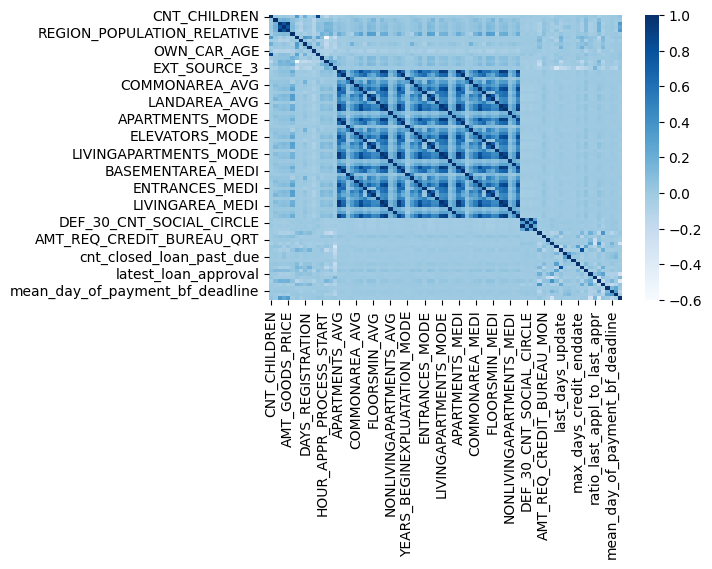

In [19]:
df_corr = calculate_correlation_matrix_with_nan(df_train_features, list_col_name_numeric=list_col_name_numeric)

plt.figure(figsize=(5.7, 3.7))
sns.heatmap(df_corr, cmap="Blues")
plt.show()

In [20]:
# determine correlated columns (using threshold .8)
list_col_remove = remove_correlate_features(df_corr)
df_train_features.drop(columns=list_col_remove, inplace=True)

# update numerical features
list_col_name_numeric = [col for col in list_col_name_numeric if col not in list_col_remove]

In [21]:
# [Save] list of correlated features
path_list_correlated_cols = os.path.join(dir_preprocess_data_artifacts, 'list_col_name_correlated.sav')
joblib.dump(list_col_remove, path_list_correlated_cols)

['c:\\Users\\11413929\\repos\\int_ass\\data\\process\\objects\\list_col_name_correlated.sav']

In [23]:
df_train_features.isnull().sum()

SK_ID_CURR                             0
TARGET                                 0
NAME_CONTRACT_TYPE                     0
CODE_GENDER                            0
FLAG_OWN_CAR                           0
                                   ...  
is_req_ins_on_appr                     0
cnt_mth_past_due                   26315
mean_day_of_payment_bf_deadline    15876
ratio_payment_short                15876
ratio_max_amt_credit               16682
Length: 80, dtype: int64

#### <u>Step 6</u>: Remove heavy NaN col

In [28]:
list_col_heavy_nan = list_heavy_nan_col(df_train_features, threshold=0.4)

df_train_features.drop(columns=list_col_heavy_nan, inplace=True)

# update column definition
for col in list_col_heavy_nan:
    if col in list_col_name_nominal:
        list_col_name_nominal.remove(col)
    if col in list_col_name_numeric:
        list_col_name_numeric.remove(col)

In [29]:
# [Save] list of heavy NaN col and preprocessed features
path_df_train_features = os.path.join(dir_preprocess_data_features, 'feature_train.csv')
df_train_features.to_csv(path_df_train_features, index=False)

path_list_col_heavy_nan = os.path.join(dir_preprocess_data_artifacts, 'list_col_name_heavy_nan.sav')
joblib.dump(list_col_heavy_nan, path_list_col_heavy_nan)

['c:\\Users\\11413929\\repos\\int_ass\\data\\process\\objects\\list_col_name_heavy_nan.sav']

#### <u>Step 6</u>: Train-valid-test split

In [30]:
X = df_train_features.drop(columns=col_name_id)
Y = df_train_features[col_name_target]
X.drop(columns=col_name_target, inplace=True)

X_train, X_valid_test, Y_train, Y_valid_test = train_test_split(X, Y, train_size=0.8, random_state=RANDOM_SEED, stratify=Y, shuffle=True)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid_test, Y_valid_test, train_size=0.5, random_state=RANDOM_SEED, stratify=Y_valid_test, shuffle=True)

In [31]:
del X_valid_test
del Y_valid_test

#### <u>Step 7</u>: Nominal Encoder (fit single object)

In [33]:
X_train, list_col_object, categories_ = preprocess_nominal(X_train, list_nominal_col=list_col_name_nominal, fit_encoder=True, dict_category=dict_category)

# fit encoder
encoder = fit_encoder_exp(X_train.loc[:, list_col_object], categories=categories_, handle_unknown='ignore', sparse_output=False)

# transform encoder
X_train = transform_encoder_exp(X_train, list_col_object, encoder)

#### <u>Step 8</u>: Scaler (fit single object)

In [34]:
# fit scaler
scaler = fit_scaler_exp(X_train.loc[:, list_col_name_numeric])

# transform encoder
X_train = transform_scaler_exp(X_train, list_col_name_numeric, scaler)

#### <u>Step 9</u>: Preprocess on Validation and Testing set

In [35]:
# preprocessing on X_valid
X_valid = transform_encoder_exp(X_valid, list_col_object, encoder)
X_valid = transform_scaler_exp(X_valid, list_col_name_numeric, scaler)

X_test = transform_encoder_exp(X_test, list_col_object, encoder)
X_test = transform_scaler_exp(X_test, list_col_name_numeric, scaler)

In [36]:
# Checking data shape
print("Training features shape --> {}, Training target shape --> {}".format(X_train.shape, Y_train.shape))
print("Validation features shape --> {}, Validation target shape --> {}".format(X_valid.shape, Y_valid.shape))
print("Testing features shape --> {}, Testing target shape --> {}".format(X_test.shape, Y_test.shape))

Training features shape --> (246008, 102), Training target shape --> (246008,)
Validation features shape --> (30751, 102), Validation target shape --> (30751,)
Testing features shape --> (30752, 102), Testing target shape --> (30752,)


In [151]:
# [Save] all the data for training
save_features_target(X_train, Y_train.values, save_dir=dir_preprocess_data_model_train)
save_features_target(X_valid, Y_valid.values, save_dir=dir_preprocess_data_model_valid)
save_features_target(X_test, Y_test.values, save_dir=dir_preprocess_data_model_test)

#### <u>Step 9.5</u>: Preprocess object (Pipeline)

In [79]:
numeric_processor = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_processor = Pipeline(steps=[('encoder', OneHotEncoder(categories=categories_, handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_processor, list_col_name_numeric), 
                                               ('category', categorical_processor, list_col_object)])
# preprocessor

# PART III - Model Training

In [6]:
X_train, Y_train = load_feature_target(save_dir=dir_preprocess_data_model_train)
X_valid, Y_valid = load_feature_target(save_dir=dir_preprocess_data_model_valid)
X_test, Y_test = load_feature_target(save_dir=dir_preprocess_data_model_test)

Y_train = pd.Series(Y_train, index=X_train.index)
Y_valid = pd.Series(Y_valid, index=X_valid.index)
Y_test = pd.Series(Y_test, index=X_test.index)

In [42]:
# function
def get_resource_utilize() -> int:
    cpu_count = os.cpu_count()
    if cpu_count > 1:
        half_cpu_cnt = cpu_count / 2
        resource_util = math.floor(half_cpu_cnt)
    else:
        resource_util = cpu_count

    return resource_util


def accuracy_report(y_true: Union[np.array, pd.Series], y_pred: np.array) -> None:
    str_confusion_matrix = str(confusion_matrix(y_true, y_pred))\
                                .replace('[[', ' ' * 5 + '[[')\
                                .replace('\n ', '\n' + ' ' * 6)
    
    print("Confusion Matrix : \n{}".format(str_confusion_matrix))
    print("Accuracy Score : {0:.2f}".format(accuracy_score(y_true, y_pred)))
    print("Precision Score : {0:.2f}".format(precision_score(y_true, y_pred)))
    print("Recall Score : {0:.2f}".format(recall_score(y_true, y_pred)))
    print("F1 Score : {0:.2f}".format(f1_score(y_true, y_pred)))


def fit_feature_selector(model_selector, X_train: pd.DataFrame, Y_train: Union[np.array, pd.Series]) -> pd.Series:
    arr_cnt_row_nan = X_train.isnull().sum(axis=1)
    filter_out_row_nan = arr_cnt_row_nan.eq(0)

    X_train_non_nan = X_train.loc[filter_out_row_nan]
    Y_train_non_nan = Y_train[filter_out_row_nan]

    model_selector.fit(X_train_non_nan, Y_train_non_nan)
    feature_importances = pd.Series(model_selector.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    return feature_importances


def explore_number_of_feature(model_exp, feature_importances: np.array, X_train: pd.DataFrame, Y_train: Union[np.array, pd.Series],
                              n_col_start: int = 20, n_col_end: int = 110, n_col_skip: int = 5, highlight_n_feature: Optional[int] = None, **kwargs):
    list_roc_train = []
    list_roc_valid = []

    for n_features in range(n_col_start, n_col_end, n_col_skip):
        col_selected = feature_importances.iloc[:n_features].index.tolist()

        # fit experiment model
        model = clone(model_exp)
        model.fit(X_train.loc[:, col_selected], Y_train, **kwargs)

        # prediction
        y_train_prob_pred = model.predict_proba(X_train.loc[:, col_selected])[:, 1]
        y_valid_prob_pred = model.predict_proba(X_valid.loc[:, col_selected])[:, 1]

        # calculate roc score
        roc_auc_score_train = roc_auc_score(Y_train, y_train_prob_pred)
        roc_auc_score_valid = roc_auc_score(Y_valid, y_valid_prob_pred)

        list_roc_train.append(roc_auc_score_train)
        list_roc_valid.append(roc_auc_score_valid)

    list_x_label = list(range(n_col_start, n_col_end, n_col_skip))

    # plot graph
    plt.figure(figsize=(6, 4))
    plt.plot(list_x_label, list_roc_train, label='AUC Train')
    plt.plot(list_x_label, list_roc_valid, label='AUC valid')
    plt.legend()
    plt.title('Comparison of AUC values in Training and Valiation Set for each N features\n')
    plt.xlabel('N features')
    plt.ylabel('AUC score')
    if highlight_n_feature is not None:
        plt.axvline(x=highlight_n_feature, linestyle='--', color='black')
    plt.show()


def re_select_features(feature_importances: pd.Series, n_features: int) -> List[str]:
    top_n_features = feature_importances.iloc[:n_features]

    return top_n_features.index.tolist()


def grid_search_cv(est, grid_params: dict, X_train: pd.DataFrame, Y_train: Union[pd.Series, np.array], 
                   X_valid: pd.DataFrame, Y_valid: Union[np.array, pd.Series], **kwargs) -> pd.DataFrame:
    X = pd.concat([X_train, X_valid])
    Y = np.concatenate([Y_train, Y_valid])

    n_row_train = X_train.shape[0]
    n_row_valid = X_valid.shape[0]
    list_indices = [-1] * n_row_train + [0] * n_row_valid

    ps = PredefinedSplit(test_fold=list_indices)

    search_params = GridSearchCV(est, param_grid=grid_params, scoring="roc_auc", refit=False,
                                  cv=ps, return_train_score=True)

    search_params.fit(X, Y, **kwargs)

    df_cv_results = pd.DataFrame(search_params.cv_results_)
    
    return df_cv_results.sort_values(by="rank_test_score")

In [8]:
# get resource util
N_JOBS = get_resource_utilize()

N_FEATURES = 60

In [9]:
# compute class weight
arr_unique_class = np.unique(Y_train)
arr_class_weight = compute_class_weight(class_weight="balanced", classes=arr_unique_class, y=Y_train)
dict_class_weight = dict(zip(arr_unique_class, arr_class_weight))

# compute class weight (for only feature selection model)
arr_cnt_row_nan = X_train.isnull().sum(axis=1)
filter_out_row_nan = arr_cnt_row_nan.eq(0)

arr_unique_class_f = np.unique(Y_train[filter_out_row_nan])
arr_class_weight_f = compute_class_weight(class_weight="balanced", classes=arr_unique_class_f, y=Y_train[filter_out_row_nan])
dict_class_weight_f = dict(zip(arr_unique_class_f, arr_class_weight_f))

In [10]:
# calculate feature importance
model_selector = RandomForestClassifier(max_depth=None, n_jobs=N_JOBS, class_weight=dict_class_weight_f, random_state=RANDOM_SEED)
feature_importances = fit_feature_selector(model_selector, X_train, Y_train)

### <u>Model I</u>: Decision Tree Classifier

#### 1) Feature Selection

In [87]:
# feature selection : SelectFromModel
model_selector = RandomForestClassifier(max_depth=None, n_jobs=N_JOBS, class_weight=dict_class_weight_f, random_state=RANDOM_SEED)
feature_selector = SelectFromModel(estimator=model_selector, threshold=-np.inf, max_features=N_FEATURES)

feature_selector.fit(X_train.loc[filter_out_row_nan], Y_train[filter_out_row_nan])

arr_bool_feature_mask = feature_selector.get_support()
list_selected_features = X_train.columns[arr_bool_feature_mask].tolist()

In [152]:
Y_train[filter_out_row_nan].value_counts()

TARGET
0    98836
1     8363
Name: count, dtype: int64

In [96]:
print("Selected features: {}".format(list_selected_features))

Selected features: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'cnt_active_loan', 'last_days_update', 'cnt_active_loan_past_due', 'cnt_closed_loan_past_due', 'max_days_credit_enddate', 'total_amt_credit_sum_debt', 'is_all_loan_approved', 'is_loan_refused_within_curr_period', 'is_loan_canceled_within_curr_period', 'latest_loan_approval', 'ratio_last_appl_to_last_appr', 'max_amt_credit', 'min_days_last_due', 'is_req_ins_on_appr', 'cnt_mth_past_due', 'mean_day_of_payment_bf_deadline', 'ratio_payment_short', 'rati

#### 2) Model Training: Version 0 (Baseline Model)

<em>--> Current baseline score of "Area under ROC curve"</em> : <b>0.714</b>

In [89]:
model_v0 = DecisionTreeClassifier(max_depth=7, class_weight=dict_class_weight, random_state=RANDOM_SEED)
model_v0.fit(X_train.loc[:, list_selected_features], Y_train)

DecisionTreeClassifier(class_weight={0: 0.5439092983356032,
                                     1: 6.193554884189325},
                       max_depth=7)

In [90]:
y_train_pred = model_v0.predict(X_train.loc[:, list_selected_features])
y_valid_pred = model_v0.predict(X_valid.loc[:, list_selected_features])

y_train_prob_pred = model_v0.predict_proba(X_train.loc[:, list_selected_features])[:, 1]
y_valid_prob_pred = model_v0.predict_proba(X_valid.loc[:, list_selected_features])[:, 1]

In [91]:
roc_auc_score_train = roc_auc_score(Y_train, y_train_prob_pred)
roc_auc_score_valid = roc_auc_score(Y_valid, y_valid_prob_pred)

print("Area under ROC curve for Training set: {}".format(roc_auc_score_train))
print("Area under ROC curve for Validation set: {} ***".format(roc_auc_score_valid))

Area under ROC curve for Training set: 0.7234009023776302
Area under ROC curve for Validation set: 0.7138701063733022 ***


In [92]:
# addition inspection on accuracy
print("-" * 48)
print("Additional Accuracy on Training Set")
print("-" * 48)
accuracy_report(Y_train, y_train_pred)
print("-" * 48)
print("Additional Accuracy on Validation Set")
print("-" * 48)
accuracy_report(Y_valid, y_valid_pred)

------------------------------------------------
Additional Accuracy on Training Set
------------------------------------------------
Confusion Matrix : 
     [[148390  77758]
      [  6349  13511]]
Accuracy Score : 0.66
Precision Score : 0.15
Recall Score : 0.68
F1 Score : 0.24
------------------------------------------------
Additional Accuracy on Validation Set
------------------------------------------------
Confusion Matrix : 
     [[18411  9858]
      [  793  1689]]
Accuracy Score : 0.65
Precision Score : 0.15
Recall Score : 0.68
F1 Score : 0.24


As we can see, the precision score is quite low --> May be adding model complexity and/or selected features for training model could help

#### 3) Model Training: Version 1
<u>Details</u>
 - Decision Tree Classifier algorithm
 - Adding / reducing features
 - Adding model complexity : max_depth, min_samples_leaf, etc.

 <em>--> Current v1 score of "Area under ROC curve"</em> : <b>0.723</b>

##### 3.1) Studying effect of more feature added to model

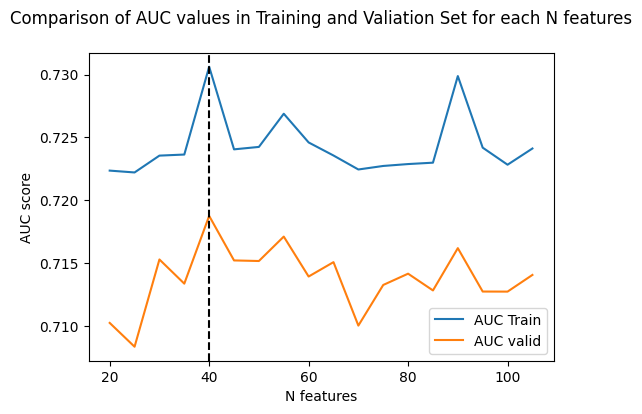

In [116]:
# experiment on decision tree model
model_exp = DecisionTreeClassifier(max_depth=7, class_weight=dict_class_weight, random_state=RANDOM_SEED)
explore_number_of_feature(model_exp, feature_importances, X_train, Y_train, highlight_n_feature=40)

Limit the number of selected features to 40

In [119]:
# re-select feature
list_selected_features = re_select_features(feature_importances, 40)

##### 3.2) Adding model complexity (Hyperparameter Tuning)

Considered parameter space
- min_samples_leaf = [0.01, 0.02, 0.05, 0.1]
- criterion = ["gini", "entropy", "log_loss"]

In [140]:
# selected parameter:
# - min_samples_leaf: 0.01
# - criterion: "entropy"

param_grid = {
    "min_impurity_decrease": [0, 0.0001, 0.001]
}
initial_model = DecisionTreeClassifier(class_weight=dict_class_weight, random_state=RANDOM_SEED, min_samples_leaf=0.01, criterion="entropy")

X_train_s = X_train.loc[:, list_selected_features]
X_valid_s = X_valid.loc[:, list_selected_features]

df_cv_results = grid_search_cv(initial_model, param_grid, X_train=X_train_s, X_valid=X_valid_s, Y_train=Y_train, Y_valid=Y_valid)

In [141]:
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_impurity_decrease,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,4.616141,0.0,0.018247,0.0,0,{'min_impurity_decrease': 0},0.721075,0.721075,0.0,1,0.720372,0.720372,0.0
1,4.344450,0.0,0.015927,0.0,0.0001,{'min_impurity_decrease': 0.0001},0.721031,0.721031,0.0,2,0.720142,0.720142,0.0
2,3.443967,0.0,0.014611,0.0,0.001,{'min_impurity_decrease': 0.001},0.708119,0.708119,0.0,3,0.705883,0.705883,0.0


##### \[Final Model\]: Version 1

In [142]:
model_v1 = DecisionTreeClassifier(class_weight=dict_class_weight, random_state=RANDOM_SEED, min_samples_leaf=0.01, criterion="entropy")
model_v1.fit(X_train.loc[:, list_selected_features], Y_train)

DecisionTreeClassifier(class_weight={0: 0.5439092983356032,
                                     1: 6.193554884189325},
                       criterion='entropy', min_samples_leaf=0.01,
                       random_state=99)

In [143]:
y_train_pred = model_v1.predict(X_train.loc[:, list_selected_features])
y_valid_pred = model_v1.predict(X_valid.loc[:, list_selected_features])

y_train_prob_pred = model_v1.predict_proba(X_train.loc[:, list_selected_features])[:, 1]
y_valid_prob_pred = model_v1.predict_proba(X_valid.loc[:, list_selected_features])[:, 1]

In [144]:
roc_auc_score_train = roc_auc_score(Y_train, y_train_prob_pred)
roc_auc_score_valid = roc_auc_score(Y_valid, y_valid_prob_pred)

print("Area under ROC curve for Training set: {}".format(roc_auc_score_train))
print("Area under ROC curve for Validation set: {} ***".format(roc_auc_score_valid))

Area under ROC curve for Training set: 0.7260337036591337
Area under ROC curve for Validation set: 0.7225582651349222 ***


#### 4) Model Training: Version 2
<u>Details</u>
 - Random Forest Classifier algorithm
 - Adding / reducing features
 - Adding model complexity : max_depth, min_samples_leaf, etc.

 <em>--> Current v2 score of "Area under ROC curve"</em> : <b>0.741</b>

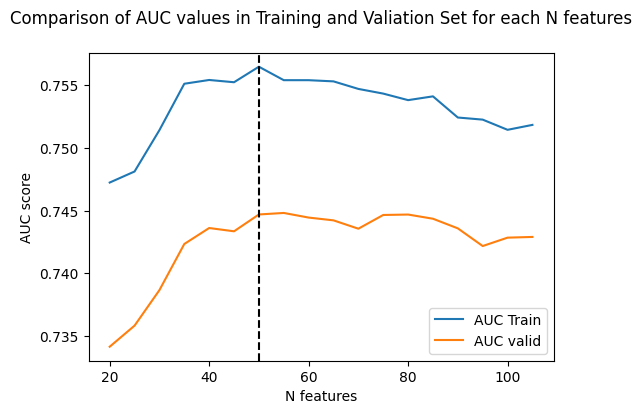

In [164]:
# experiment on random forest model
model_exp = RandomForestClassifier(max_depth=7, class_weight=dict_class_weight, random_state=RANDOM_SEED, n_jobs=N_JOBS)
explore_number_of_feature(model_exp, feature_importances, X_train, Y_train, highlight_n_feature=50)

Limit the number of selected features to 50

In [11]:
# re-select feature
list_selected_features = re_select_features(feature_importances, 50)

Considered parameter space
- min_samples_leaf = [0.01, 0.02, 0.05, 0.1] (with pre-defined max features)
- criterion = ["gini", "entropy", "log_loss"] (with pre-defined max features)
- n_estimators = [50, 100, 150, 200, 250] (with previous settings)
- max_features = ['sqrt', 'log2', 0.4, 0.2, 0.3] (with previous settings)
- max_samples = [0.6, 0.7, 0.8, 0.9, 1.0] (with previous settings)

In [24]:
# selected parameter:
# - min_samples_leaf: 0.01
# - criterion: "entropy"
# - n_estimators: 100
# - max_features: 'log2'
# - max_samples: 0.8

param_grid = {
    "max_samples": [0.6, 0.7, 0.8, 0.9, 1.0]
}
initial_model = RandomForestClassifier(n_jobs=N_JOBS, class_weight=dict_class_weight, random_state=RANDOM_SEED,
                                       min_samples_leaf=0.01, criterion='entropy', n_estimators=100, max_features='log2')

X_train_s = X_train.loc[:, list_selected_features]
X_valid_s = X_valid.loc[:, list_selected_features]

df_cv_results = grid_search_cv(initial_model, param_grid, X_train=X_train_s, X_valid=X_valid_s, Y_train=Y_train, Y_valid=Y_valid)

In [25]:
df_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_samples,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
3,4.270422,0.0,0.051094,0.0,0.9,{'max_samples': 0.9},0.741479,0.741479,0.0,1,0.740184,0.740184,0.0
2,4.143750,0.0,0.053053,0.0,0.8,{'max_samples': 0.8},0.741454,0.741454,0.0,2,0.739760,0.739760,0.0
4,4.620560,0.0,0.052128,0.0,1.0,{'max_samples': 1.0},0.741390,0.741390,0.0,3,0.740668,0.740668,0.0
1,4.227380,0.0,0.050009,0.0,0.7,{'max_samples': 0.7},0.741377,0.741377,0.0,4,0.738553,0.738553,0.0
0,3.503317,0.0,0.052094,0.0,0.6,{'max_samples': 0.6},0.741016,0.741016,0.0,5,0.738321,0.738321,0.0


##### \[Final Model\]: Version 2

In [ ]:
model_v2 = RandomForestClassifier(n_jobs=N_JOBS, class_weight=dict_class_weight, random_state=RANDOM_SEED,
                                  min_samples_leaf=0.01, criterion='entropy', n_estimators=100, max_features='log2', max_samples=0.8)
model_v2.fit(X_train.loc[:, list_selected_features], Y_train)

In [27]:
y_train_pred = model_v2.predict(X_train.loc[:, list_selected_features])
y_valid_pred = model_v2.predict(X_valid.loc[:, list_selected_features])

y_train_prob_pred = model_v2.predict_proba(X_train.loc[:, list_selected_features])[:, 1]
y_valid_prob_pred = model_v2.predict_proba(X_valid.loc[:, list_selected_features])[:, 1]

In [28]:
roc_auc_score_train = roc_auc_score(Y_train, y_train_prob_pred)
roc_auc_score_valid = roc_auc_score(Y_valid, y_valid_prob_pred)

print("Area under ROC curve for Training set: {}".format(roc_auc_score_train))
print("Area under ROC curve for Validation set: {} ***".format(roc_auc_score_valid))

Area under ROC curve for Training set: 0.7397595862282418
Area under ROC curve for Validation set: 0.7414544293001372 ***


In [29]:
# addition inspection on accuracy
print("-" * 48)
print("Additional Accuracy on Training Set")
print("-" * 48)
accuracy_report(Y_train, y_train_pred)
print("-" * 48)
print("Additional Accuracy on Validation Set")
print("-" * 48)
accuracy_report(Y_valid, y_valid_pred)

------------------------------------------------
Additional Accuracy on Training Set
------------------------------------------------
Confusion Matrix : 
     [[150963  75185]
      [  6147  13713]]
Accuracy Score : 0.67
Precision Score : 0.15
Recall Score : 0.69
F1 Score : 0.25
------------------------------------------------
Additional Accuracy on Validation Set
------------------------------------------------
Confusion Matrix : 
     [[18757  9512]
      [  749  1733]]
Accuracy Score : 0.67
Precision Score : 0.15
Recall Score : 0.70
F1 Score : 0.25


#### 5) Model Training: Version 3
<u>Details</u>
 - Random Forest Classifier algorithm
 - Adding / reducing features
 - Adding model complexity : max_depth, min_samples_leaf, etc.

 <em>--> Current v3 score of "Area under ROC curve"</em> : <b>0.765</b>

In [33]:
sample_weights = compute_sample_weight(class_weight="balanced", y=Y_train)

c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

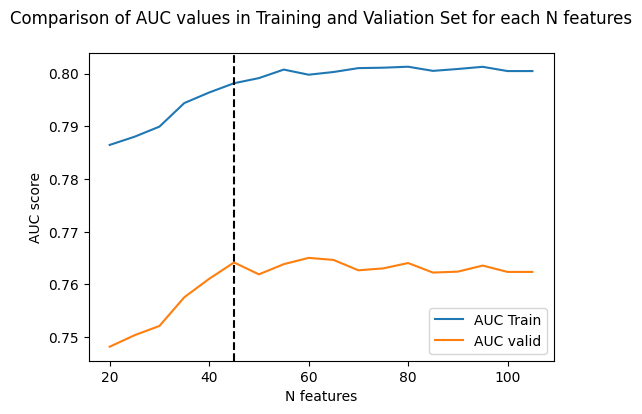

In [86]:
# experiment on random forest model
model_exp = xgb.XGBClassifier(max_depth=4, random_state=RANDOM_SEED, n_jobs=N_JOBS)
explore_number_of_feature(model_exp, feature_importances, X_train, Y_train, highlight_n_feature=45, sample_weight=sample_weights)

Limit the number of selected features to 60

In [87]:
# re-select feature
list_selected_features = re_select_features(feature_importances, 45)

Considered parameter space
- parameter set 1
  - n_estimators = [50, 75, 100, 120, 150, 200] 
  - learning_rate = [.001, .005, .01, .03, .1, .3]
- parameter set 2 (with pre-defined previous parameters)
  - max_depth = [4, 5, 6] 
  - min_child_weight = [3, 5, 7, 9]
- gamma (skip since we specify shallow max_depth together with specified min_child_weight)
- reg_alpha = [.01, .1, 1, 2, 5, 10] (with pre-defined previous parameters)
- reg_lambda = [.01, .1, 1, 2, 5, 10] (with pre-defined previous parameters)
- subsample = [.6, .7, .8, .9, 1.] (with pre-defined previous parameters)
- colsample_bytree = [.2, .4, .6, .8, 1.] (with pre-defined previous parameters)

In [90]:
# selected parameter:
# - n_estimators: 100 - 150 (125)
# - learning_rate: 0.1 - 0.2 (0.1)
# - max_depth: 4 - 6 (5)
# - min_child_weight: 5 - 9 (5)
# - gamma (skip)
# - reg_alpha: 1 - 5 (2)
# - reg_lambda: 2 - 5 (2)
# - subsample: 1.
# - colsample_bytree: 0.6

param_grid = {
    "colsample_bytree": [.2, .4, .6, .8, 1.]
}
initial_model = xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=N_JOBS, 
                                  n_estimators=125, learning_rate=0.1, max_depth=5, min_child_weight=5, reg_alpha=2, reg_lambda=2)

X_train_s = X_train.loc[:, list_selected_features]
X_valid_s = X_valid.loc[:, list_selected_features]

df_cv_results = grid_search_cv(initial_model, param_grid, X_train=X_train_s, X_valid=X_valid_s, Y_train=Y_train, Y_valid=Y_valid, sample_weight=sample_weights)

c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

In [91]:
df_cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bynode,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
4,2.051312,0.0,0.030659,0.0,1.0,{'colsample_bynode': 1.0},0.765084,0.765084,0.0,1,0.797247,0.797247,0.0
1,2.249388,0.0,0.029075,0.0,0.4,{'colsample_bynode': 0.4},0.763348,0.763348,0.0,2,0.793103,0.793103,0.0
2,2.072205,0.0,0.028610,0.0,0.6,{'colsample_bynode': 0.6},0.763347,0.763347,0.0,3,0.795383,0.795383,0.0
3,2.133974,0.0,0.029088,0.0,0.8,{'colsample_bynode': 0.8},0.763175,0.763175,0.0,4,0.796351,0.796351,0.0
0,2.348919,0.0,0.025064,0.0,0.2,{'colsample_bynode': 0.2},0.763064,0.763064,0.0,5,0.788947,0.788947,0.0


##### \[Final Model\]: Version 3

In [92]:
model_v3 = xgb.XGBClassifier(random_state=RANDOM_SEED, n_jobs=N_JOBS, 
                             n_estimators=125, learning_rate=0.1, max_depth=5, min_child_weight=5, reg_alpha=2, reg_lambda=2, colsample_bytree=.6)
model_v3.fit(X_train.loc[:, list_selected_features], Y_train)

c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=125, n_jobs=8,
              num_parallel_tree=None, random_state=99, ...)

In [93]:
y_train_pred = model_v3.predict(X_train.loc[:, list_selected_features])
y_valid_pred = model_v3.predict(X_valid.loc[:, list_selected_features])

y_train_prob_pred = model_v3.predict_proba(X_train.loc[:, list_selected_features])[:, 1]
y_valid_prob_pred = model_v3.predict_proba(X_valid.loc[:, list_selected_features])[:, 1]

c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\11413929\AppData\Local\miniconda3\envs\r_atm_poc\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

In [94]:
roc_auc_score_train = roc_auc_score(Y_train, y_train_prob_pred)
roc_auc_score_valid = roc_auc_score(Y_valid, y_valid_prob_pred)

print("Area under ROC curve for Training set: {}".format(roc_auc_score_train))
print("Area under ROC curve for Validation set: {} ***".format(roc_auc_score_valid))

Area under ROC curve for Training set: 0.7897273830747702
Area under ROC curve for Validation set: 0.7645906446325818 ***


## Playground (delete later)